<a href="https://colab.research.google.com/github/Csrivastava003/A-Comparative-study-of-various-Machine-Learning-approaches-in-predicting-EV-charge-demand-/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Initialization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pip install darts

In [ ]:
def create_dataset(actual,predicted,name):
  data={"Actual":actual,"Predicted":predicted}
  df = pd.DataFrame(data)
  df.to_csv(name)

### Caltech

In [ ]:
caltech=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/caltech_data")

In [ ]:
caltech.head()

Date    Power    Duration
0  2018-04-25  340.829  359.401667
1  2018-04-26  395.559  318.657500
2  2018-04-27  377.277  258.767500
3  2018-04-28  491.323  266.875833
4  2018-04-29  302.455  112.535556

In [ ]:
caltech.tail()

Date    Power    Duration
1080  2021-09-10  432.430  134.493611
1081  2021-09-11  193.040   33.257500
1082  2021-09-12  251.265   17.702778
1083  2021-09-13  506.718  129.661389
1084  2021-09-14   45.064    1.209167

In [ ]:
caltech.describe()

Power     Duration
count  1085.000000  1085.000000
mean    267.995555   163.697958
std     216.083387   160.583120
min       0.591000     0.193611
25%      92.280000    25.869444
50%     223.996000   102.433056
75%     372.194000   255.180556
max     959.573858   673.164722

In [ ]:
caltech.shape

(1085, 3)

### JPL

In [ ]:
jpl=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/jpl_data")

In [ ]:
jpl=jpl.drop(columns=["Date.1"])

In [ ]:
jpl.head()

Date    Power
0  2018-09-05  245.799
1  2018-09-06  441.490
2  2018-09-07  462.517
3  2018-09-08   49.125
4  2018-09-09   22.435

In [ ]:
jpl.tail()

Date    Power
951  2021-09-10  138.765
952  2021-09-11    9.554
953  2021-09-12   84.675
954  2021-09-13  719.547
955  2021-09-14   55.190

###Transformers from Scratch Caltech

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau


The following code describes a simple implementation of a transformer-based **model** using PyTorch's built-in functionalities. The TransformerModel class encapsulates a transformer-based neural network designed for sequence processing. Upon initialization, the model sets up several components: an encoder to adjust the input data to a desired dimension, a pos_encoder to bestow the sequence with positional information, a core transformer_encoder comprising several layers to process the sequence, and a decoder to produce the final output. As data flows through the model during the forward pass, it undergoes a series of transformations: it's first projected to a higher dimension, then augmented with positional encodings, processed by the transformer layers, and finally, the last token's representation is harnessed to produce the output. An instance of this model is readily created and can be assigned to a computation device for further training or inference.

![Transformer Model](https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png)

In [ ]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [ ]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

In [ ]:
caltech.head()

Date    Power    Duration
0  2018-04-25  340.829  359.401667
1  2018-04-26  395.559  318.657500
2  2018-04-27  377.277  258.767500
3  2018-04-28  491.323  266.875833
4  2018-04-29  302.455  112.535556

In [ ]:
df_train=caltech[caltech["Date"]<"2021-02-01"]
df_test=caltech[caltech["Date"]>="2021-02-01"]


In [ ]:
df_train.shape,df_test.shape

((859, 3), (226, 3))

In [ ]:
df_train.shape,df_test.shape

((859, 3), (226, 3))

In [ ]:
# Data Preprocessing
caltech_train = df_train['Power'].to_numpy().reshape(-1, 1)
caltech_test = df_test['Power'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
caltech_train = scaler.fit_transform(caltech_train).flatten().tolist()
caltech_test = scaler.transform(caltech_test).flatten().tolist()

In [ ]:
def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [ ]:
def generateloader(SEQUENCE_SIZE,BATCH_SIZE):
  x_train, y_train = to_sequences(SEQUENCE_SIZE, caltech_train)
  x_test, y_test = to_sequences(SEQUENCE_SIZE, caltech_test)
  train_dataset = TensorDataset(x_train, y_train)
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

  test_dataset = TensorDataset(x_test, y_test)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
  return test_loader,train_loader,x_test,y_test,x_train, y_train

In [ ]:
def train(model,epochs,train_loader):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)
  early_stop_count = 0
  min_val_loss = float('inf')
  for epoch in range(epochs):
      model.train()
      for batch in train_loader:
          x_batch, y_batch = batch
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)

          optimizer.zero_grad()
          outputs = model(x_batch)
          loss = criterion(outputs, y_batch)
          loss.backward()
          optimizer.step()
      # Validation
      model.eval()
      val=[]
      val_losses = []
      with torch.no_grad():
          for batch in test_loader:
              x_batch, y_batch = batch
              x_batch, y_batch = x_batch.to(device), y_batch.to(device)
              outputs = model(x_batch)
              loss = criterion(outputs, y_batch)
              val_losses.append(loss.item())

      val_loss = np.mean(val_losses)
      val.append(val_loss)
      scheduler.step(val_loss)

      if val_loss < min_val_loss:
          min_val_loss = val_loss
          early_stop_count = 0
      else:
          early_stop_count += 1

      if early_stop_count >= 5:
          print("Yay Early stopping! :)")
      print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")
  return val

In [ ]:
def evaluate(model,test_loader):
  model.eval()
  predictions = []
  with torch.no_grad():
      for batch in test_loader:
            x_batch, y_batch = batch
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            predictions.extend(outputs.squeeze().tolist())
  return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [ ]:
model = TransformerModel().to(device)

In [ ]:
model

TransformerModel(
  (encoder): Linear(in_features=1, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
test_loader,train_loader,x_test,y_test,x_train, y_train=generateloader(8,128)

In [ ]:
val_losses=train(model,32,train_loader)

Epoch 1/32, Validation Loss: 0.3483
Epoch 2/32, Validation Loss: 0.5041
Epoch 3/32, Validation Loss: 0.2530
Epoch 4/32, Validation Loss: 0.1836
Epoch 5/32, Validation Loss: 0.1293
Epoch 6/32, Validation Loss: 0.1259
Epoch 7/32, Validation Loss: 0.1445
Epoch 8/32, Validation Loss: 0.1218
Epoch 9/32, Validation Loss: 0.1393
Epoch 10/32, Validation Loss: 0.1218
Epoch 11/32, Validation Loss: 0.1392
Epoch 12/32, Validation Loss: 0.1309
Epoch 13/32, Validation Loss: 0.1306
Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.
Epoch 14/32, Validation Loss: 0.1480
Yay Early stopping! :)
Epoch 15/32, Validation Loss: 0.1276
Yay Early stopping! :)
Epoch 16/32, Validation Loss: 0.1340
Yay Early stopping! :)
Epoch 17/32, Validation Loss: 0.1374
Epoch 00018: reducing learning rate of group 0 to 2.5000e-04.
Yay Early stopping! :)
Epoch 18/32, Validation Loss: 0.1304
Yay Early stopping! :)
Epoch 19/32, Validation Loss: 0.1310
Yay Early stopping! :)
Epoch 20/32, Validation Loss: 0.1483
Yay Ear

In [ ]:
predictions=evaluate(model,test_loader)
len(predictions)

218

In [ ]:
actual=scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
len(actual)

218

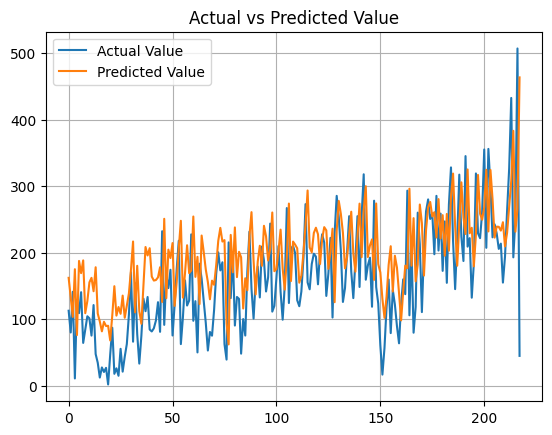

In [ ]:
plt.plot(actual, label='Actual Value')
plt.plot(predictions, label='Predicted Value')
plt.title('Actual vs Predicted Value')
plt.legend()
plt.grid(True)
plt.show()

Prediction on Training data

In [ ]:
predictions=evaluate(model,train_loader)
len(predictions)

851

In [ ]:
actual=scaler.inverse_transform(np.array(y_train).reshape(-1, 1))
len(actual)

851

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,actual)

239.41173767734946

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predictions,actual,squared=False)

303.29693224862245

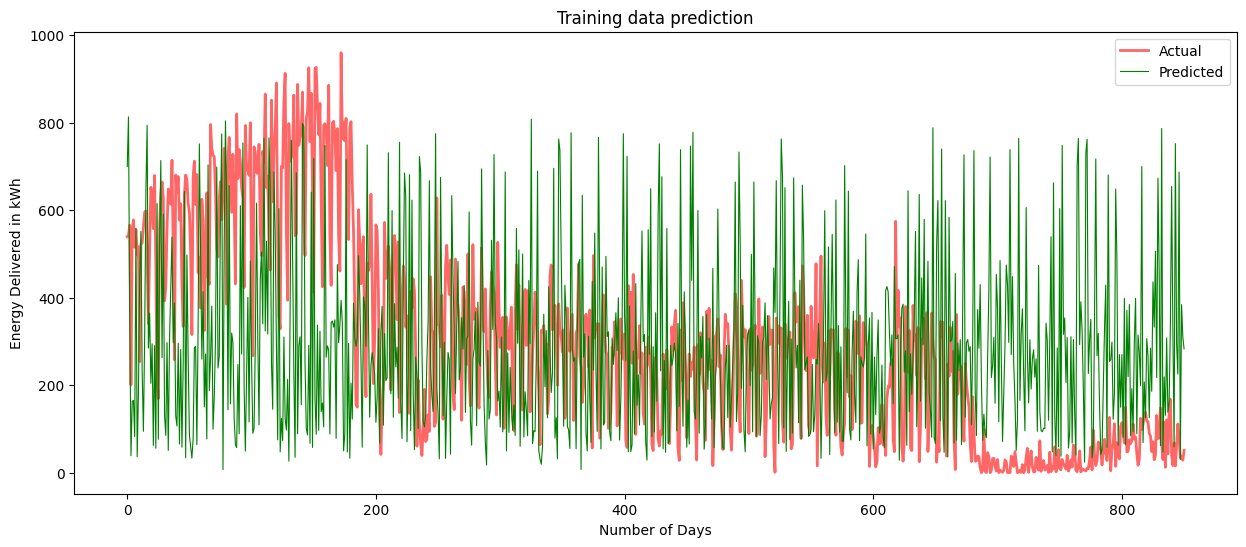

In [ ]:
plt.figure(figsize=(15,6))
plt.plot([i for i in range(851)], actual, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot([i for i in range(851)], predictions, color = 'green', linewidth=0.8)
plt.legend(['Actual','Predicted'],loc='upper right')
plt.xlabel('Number of Days')
plt.ylabel('Energy Delivered in kWh')
plt.title("Training data prediction")
plt.show()

In [ ]:
def testgenerateloader(SEQUENCE_SIZE,BATCH_SIZE,n_days):
  x_test, y_test = to_sequences(SEQUENCE_SIZE, caltech_train[:n_days])
  test_dataset = TensorDataset(x_test, y_test)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
  return test_loader,x_test,y_test

30 days prediction

In [ ]:
test_loader,x_test,y_test=testgenerateloader(8,128,38)

In [ ]:
predictions=evaluate(model,test_loader)

In [ ]:
actual=scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

In [ ]:
len(predictions),len(actual)

(30, 30)

In [ ]:
predicted=predictions[:,0]
actual=actual[:,0]
create_dataset(actual,predicted,"caltech_30days.csv")

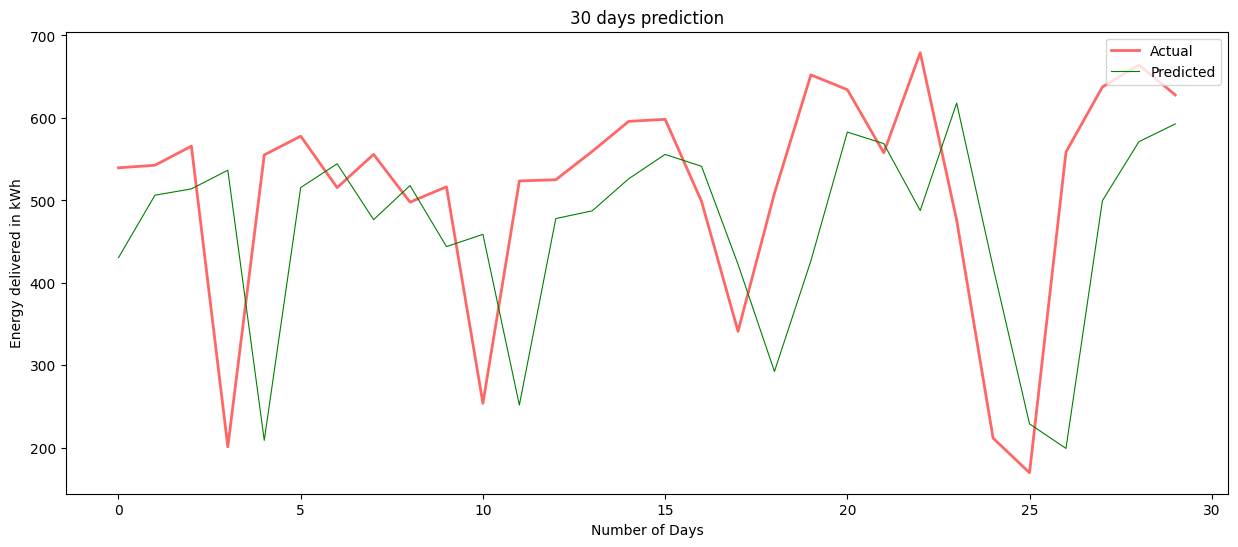

In [ ]:
plt.figure(figsize=(15,6))
plt.plot([i for i in range(30)], actual, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot([i for i in range(30)], predictions, color = 'green', linewidth=0.8)
plt.legend(['Actual','Predicted'],loc='upper right')
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh')
plt.title("30 days prediction")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,actual)

130.39102745919666

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predictions,actual,squared=False)

180.6806573904684

120 days prediction

In [ ]:
test_loader,x_test,y_test=testgenerateloader(8,128,128)

In [ ]:
predictions=evaluate(model,test_loader)

In [ ]:
actual=scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

In [ ]:
len(predictions),len(actual)

(120, 120)

In [ ]:
predicted=predictions[:,0]
actual=actual[:,0]
create_dataset(actual,predicted,"caltech_120days.csv")

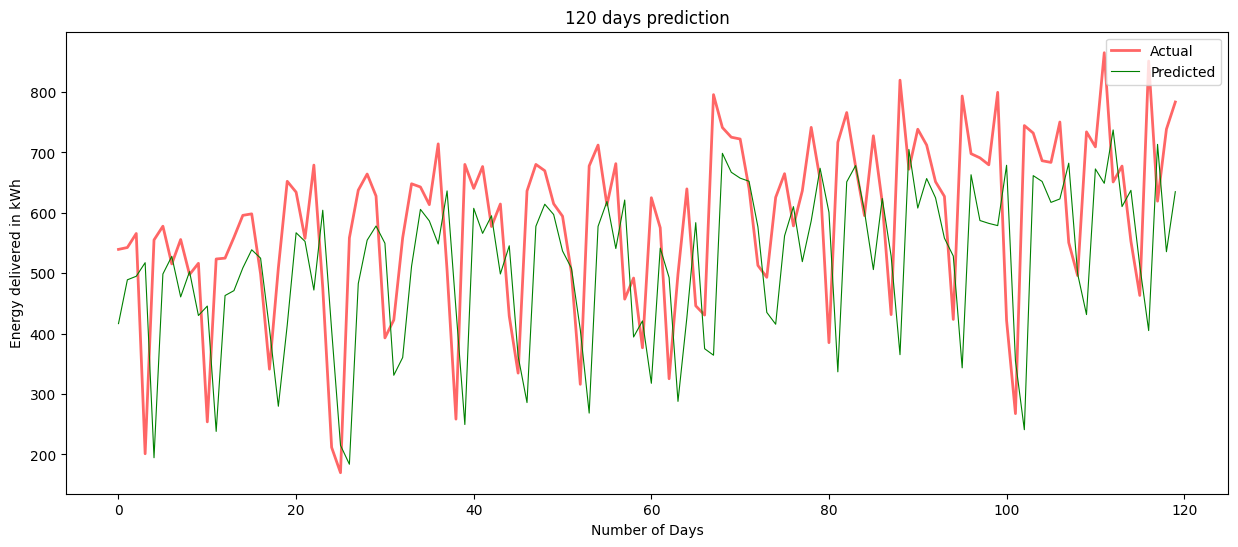

In [ ]:
plt.figure(figsize=(15,6))
plt.plot([i for i in range(120)], actual, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot([i for i in range(120)], predictions, color = 'green', linewidth=0.8)
plt.legend(['Actual','Predicted'],loc='upper right')
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh')
plt.title("120 days prediction")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,actual)

131.74672794605854

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predictions,actual,squared=False)

182.29856123425142

200 plus days prediction

In [ ]:
test_loader,x_test,y_test=testgenerateloader(8,128,226)

In [ ]:
predictions=evaluate(model,test_loader)

In [ ]:
actual=scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

In [ ]:
len(predictions),len(actual)

(218, 218)

In [ ]:
predicted=predictions[:,0]
actual=actual[:,0]
create_dataset(actual,predicted,"caltech_200days.csv")

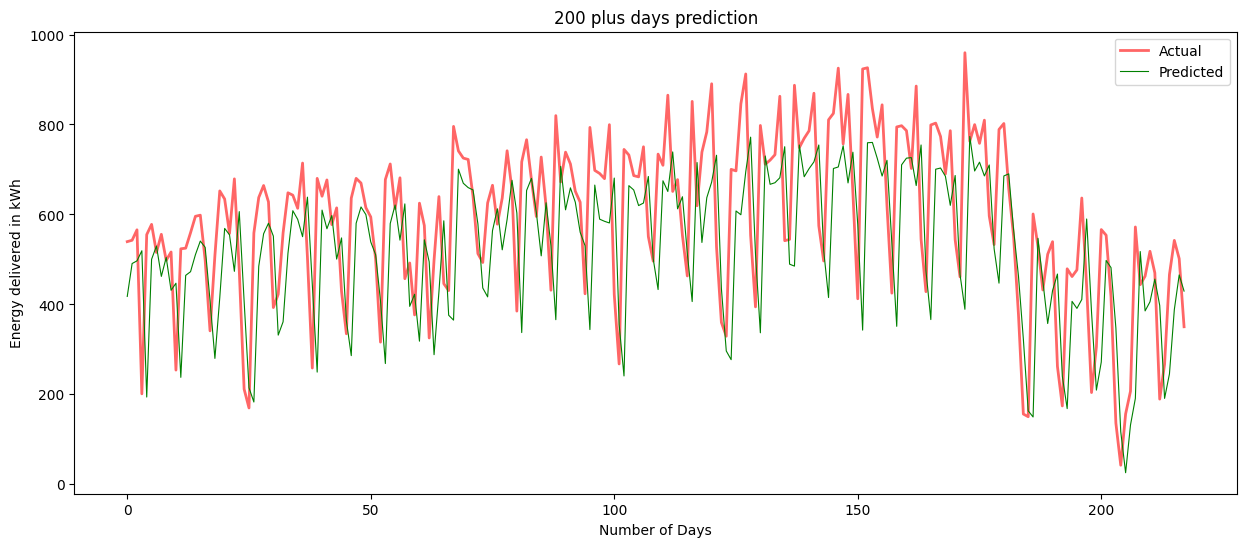

In [ ]:
plt.figure(figsize=(15,6))
plt.plot([i for i in range(218)], actual, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot([i for i in range(218)], predictions, color = 'green', linewidth=0.8)
plt.legend(['Actual','Predicted'],loc='upper right')
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh')
plt.title("200 plus days prediction")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,actual)

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predictions,actual,squared=False)

189.0890707509746

###Transformers from Scratch JPL

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau


The following code describes a simple implementation of a transformer-based **model** using PyTorch's built-in functionalities. The TransformerModel class encapsulates a transformer-based neural network designed for sequence processing. Upon initialization, the model sets up several components: an encoder to adjust the input data to a desired dimension, a pos_encoder to bestow the sequence with positional information, a core transformer_encoder comprising several layers to process the sequence, and a decoder to produce the final output. As data flows through the model during the forward pass, it undergoes a series of transformations: it's first projected to a higher dimension, then augmented with positional encodings, processed by the transformer layers, and finally, the last token's representation is harnessed to produce the output. An instance of this model is readily created and can be assigned to a computation device for further training or inference.

![Transformer Model](https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png)

In [ ]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [ ]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

In [ ]:
jpl.head()

Date    Power
0  2018-09-05  245.799
1  2018-09-06  441.490
2  2018-09-07  462.517
3  2018-09-08   49.125
4  2018-09-09   22.435

In [ ]:
df_train=jpl[jpl["Date"]<"2021-02-01"]
df_test=jpl[jpl["Date"]>="2021-02-01"]


In [ ]:
df_train.shape,df_test.shape

((742, 2), (214, 2))

In [ ]:
df_train.shape,df_test.shape

((742, 2), (214, 2))

In [ ]:
# Data Preprocessing
jpl_train = df_train['Power'].to_numpy().reshape(-1, 1)
jpl_test = df_test['Power'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
jpl_train = scaler.fit_transform(jpl_train).flatten().tolist()
jpl_test = scaler.transform(jpl_test).flatten().tolist()

In [ ]:
def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [ ]:
def generateloader(SEQUENCE_SIZE,BATCH_SIZE):
  x_train, y_train = to_sequences(SEQUENCE_SIZE, jpl_train)
  x_test, y_test = to_sequences(SEQUENCE_SIZE, jpl_test)
  train_dataset = TensorDataset(x_train, y_train)
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

  test_dataset = TensorDataset(x_test, y_test)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
  return test_loader,train_loader,x_test,y_test,x_train, y_train

In [ ]:
def train(model,epochs,train_loader):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)
  early_stop_count = 0
  min_val_loss = float('inf')
  for epoch in range(epochs):
      model.train()
      for batch in train_loader:
          x_batch, y_batch = batch
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)

          optimizer.zero_grad()
          outputs = model(x_batch)
          loss = criterion(outputs, y_batch)
          loss.backward()
          optimizer.step()
      # Validation
      model.eval()
      val=[]
      val_losses = []
      with torch.no_grad():
          for batch in test_loader:
              x_batch, y_batch = batch
              x_batch, y_batch = x_batch.to(device), y_batch.to(device)
              outputs = model(x_batch)
              loss = criterion(outputs, y_batch)
              val_losses.append(loss.item())

      val_loss = np.mean(val_losses)
      val.append(val_loss)
      scheduler.step(val_loss)

      if val_loss < min_val_loss:
          min_val_loss = val_loss
          early_stop_count = 0
      else:
          early_stop_count += 1

      if early_stop_count >= 5:
          print("Yay Early stopping! :)")
      print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")
  return val

In [ ]:
def evaluate(model,test_loader):
  model.eval()
  predictions = []
  with torch.no_grad():
      for batch in test_loader:
            x_batch, y_batch = batch
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            predictions.extend(outputs.squeeze().tolist())
  return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [ ]:
model = TransformerModel().to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
test_loader,train_loader,x_test,y_test,x_train, y_train=generateloader(8,128)

In [ ]:
val_losses=train(model,32,train_loader)

Epoch 1/32, Validation Loss: 0.5663
Epoch 2/32, Validation Loss: 0.8224
Epoch 3/32, Validation Loss: 0.2648
Epoch 4/32, Validation Loss: 0.2649
Epoch 5/32, Validation Loss: 0.3084
Epoch 6/32, Validation Loss: 0.2642
Epoch 7/32, Validation Loss: 0.2671
Epoch 8/32, Validation Loss: 0.2874
Epoch 9/32, Validation Loss: 0.2719
Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.
Epoch 10/32, Validation Loss: 0.2738
Yay Early stopping! :)
Epoch 11/32, Validation Loss: 0.2774
Yay Early stopping! :)
Epoch 12/32, Validation Loss: 0.2793
Yay Early stopping! :)
Epoch 13/32, Validation Loss: 0.2801
Epoch 00014: reducing learning rate of group 0 to 2.5000e-04.
Yay Early stopping! :)
Epoch 14/32, Validation Loss: 0.2831
Yay Early stopping! :)
Epoch 15/32, Validation Loss: 0.2845
Yay Early stopping! :)
Epoch 16/32, Validation Loss: 0.2854
Yay Early stopping! :)
Epoch 17/32, Validation Loss: 0.2864
Epoch 00018: reducing learning rate of group 0 to 1.2500e-04.
Yay Early stopping! :)
Epoch 18/3

In [ ]:
predictions=evaluate(model,test_loader)
len(predictions)

206

In [ ]:
actual=scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
len(actual)

206

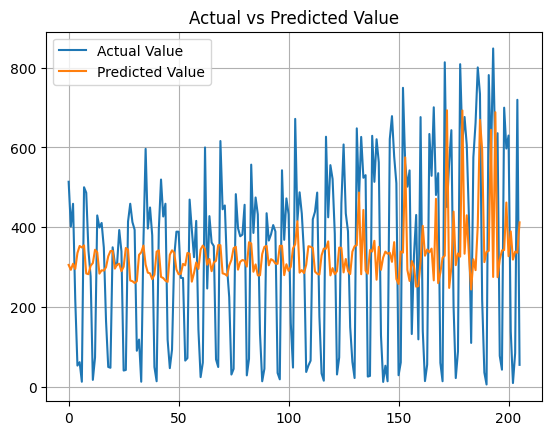

In [ ]:
plt.plot(actual, label='Actual Value')
plt.plot(predictions, label='Predicted Value')
plt.title('Actual vs Predicted Value')
plt.legend()
plt.grid(True)
plt.show()

Prediction on Training data

In [ ]:
predictions=evaluate(model,train_loader)
len(predictions)

734

In [ ]:
actual=scaler.inverse_transform(np.array(y_train).reshape(-1, 1))
len(actual)

734

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,actual)

447.68226632096633

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predictions,actual,squared=False)

531.8796147678756

In [ ]:
predicted=predictions[:,0]
actual=actual[:,0]
create_dataset(actual,predicted,"jpl_train.csv")

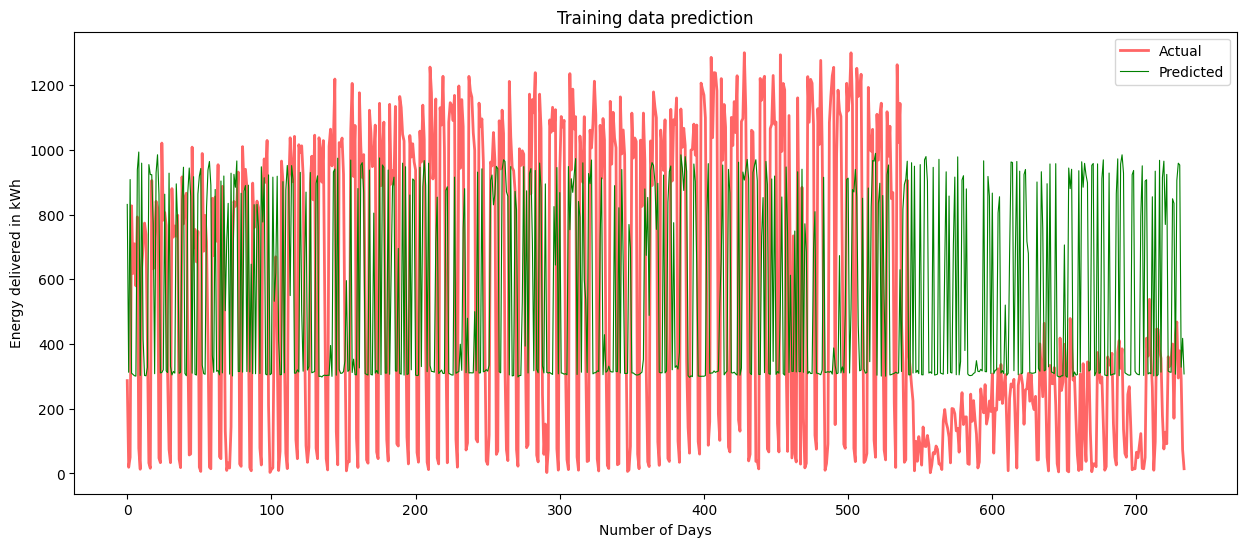

In [ ]:
plt.figure(figsize=(15,6))
plt.plot([i for i in range(734)], actual, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot([i for i in range(734)], predictions, color = 'green', linewidth=0.8)
plt.legend(['Actual','Predicted'],loc='upper right')
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh')
plt.title("Training data prediction")
plt.show()

In [ ]:
def testgenerateloader(SEQUENCE_SIZE,BATCH_SIZE,n_days):
  x_test, y_test = to_sequences(SEQUENCE_SIZE, caltech_train[:n_days])
  test_dataset = TensorDataset(x_test, y_test)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
  return test_loader,x_test,y_test

30 days prediction

In [ ]:
test_loader,x_test,y_test=testgenerateloader(8,128,38)

In [ ]:
predictions=evaluate(model,test_loader)

In [ ]:
actual=scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

In [ ]:
len(predictions),len(actual)

(30, 30)

In [ ]:
predicted=predictions[:,0]
actual=actual[:,0]
create_dataset(actual,predicted,"jpl_30days.csv")

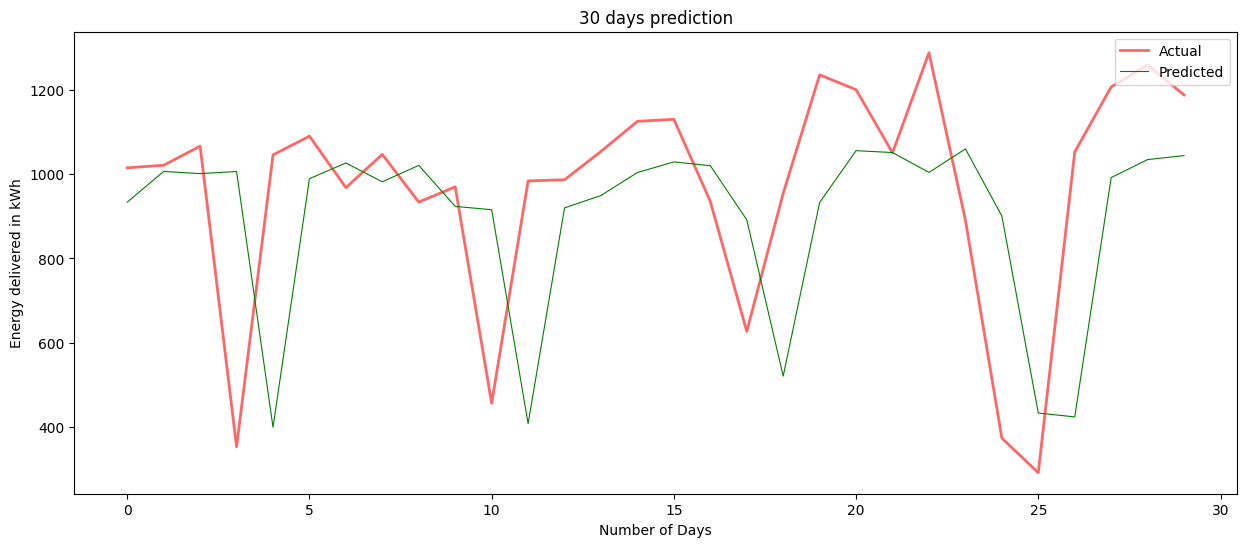

In [ ]:
plt.figure(figsize=(15,6))
plt.plot([i for i in range(30)], actual, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot([i for i in range(30)], predictions+100, color = 'green', linewidth=0.8)
plt.legend(['Actual','Predicted'],loc='upper right')
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh')
plt.title("30 days prediction")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,actual)

526.2297730535088

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predictions,actual,squared=False)

574.973801299522

120 days prediction

In [ ]:
test_loader,x_test,y_test=testgenerateloader(8,128,128)

In [ ]:
predictions=evaluate(model,test_loader)

In [ ]:
actual=scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

In [ ]:
predicted=predictions[:,0]
actual=actual[:,0]
create_dataset(actual,predicted,"jpl_120days.csv")

In [ ]:
len(predictions),len(actual)

(120, 120)

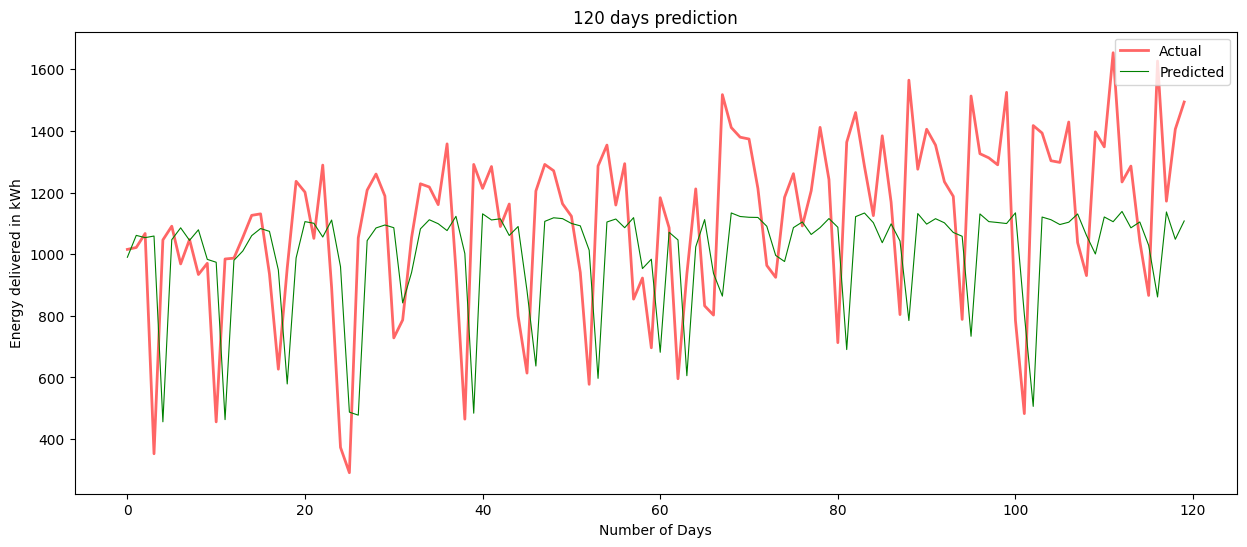

In [ ]:
plt.figure(figsize=(15,6))
plt.plot([i for i in range(120)], actual, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot([i for i in range(120)], predictions+150, color = 'green', linewidth=0.8)
plt.legend(['Actual','Predicted'],loc='upper right')
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh')
plt.title("120 days prediction")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,actual)

321.34802973010034

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predictions,actual,squared=False)

395.52001896794656

200 plus days prediction

In [ ]:
test_loader,x_test,y_test=testgenerateloader(8,128,226)

In [ ]:
predictions=evaluate(model,test_loader)

In [ ]:
actual=scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

In [ ]:
predicted=predictions[:,0]
actual=actual[:,0]
create_dataset(actual,predicted,"jpl_200days.csv")

In [ ]:
len(predictions),len(actual)

(218, 218)

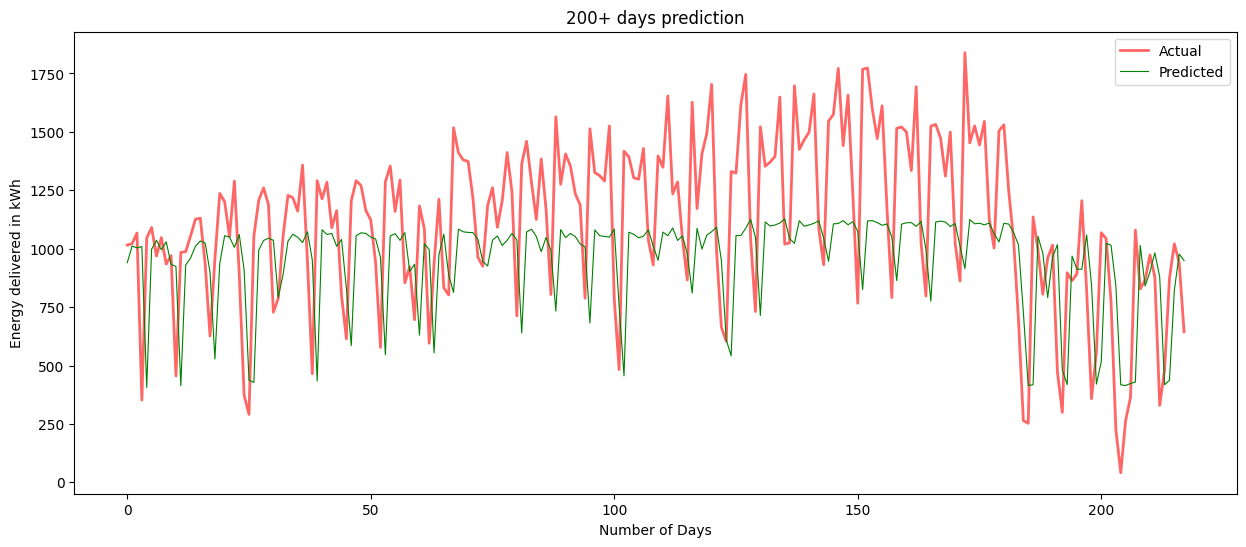

In [ ]:
plt.figure(figsize=(15,6))
plt.plot([i for i in range(218)], actual, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot([i for i in range(218)], predictions+100, color = 'green', linewidth=0.8)
plt.legend(['Actual','Predicted'],loc='upper right')
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh')
plt.title("200+ days prediction")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,actual)

341.6531218279988

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predictions,actual,squared=False)

424.0518008335911

### LSTM Caltech

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
train_start_dt = '2018-04-25'
test_start_dt = '2021-01-01'

In [ ]:
# def fillmissingvalues(df):
#   df['Date'] = pd.to_datetime(df['Date'])
#   df.set_index('Date', inplace=True)
#   return df.asfreq('D', fill_value=df['Power'].mean())

In [ ]:
df_train=caltech[caltech["Date"]<"2021-02-01"]
df_test=caltech[caltech["Date"]>="2021-02-01"]

In [ ]:
df_train.shape,df_test.shape

((859, 3), (226, 3))

In [ ]:
caltech_train = df_train['Power'].to_numpy().reshape(-1, 1)
caltech_test = df_test['Power'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
caltech_train = scaler.fit_transform(caltech_train).flatten().tolist()
caltech_test = scaler.transform(caltech_test).flatten().tolist()

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64, 32)
        self.fc2=nn.Linear(32,1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [ ]:
def train(model,epochs,test_loader):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)
  early_stop_count = 0
  min_val_loss = float('inf')
  arr=[]
  for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    arr.append(val_loss)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")
  return arr

In [ ]:
def evaluate(model,temp):
  model.eval()
  predictions = []
  with torch.no_grad():
      for batch in temp:
          x_batch, y_batch = batch
          x_batch = x_batch.to(device)
          outputs = model(x_batch)
          predictions.extend(outputs.squeeze().tolist())
  predictions
  return predictions

In [ ]:
def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [ ]:
def generateloader(SEQUENCE_SIZE,BATCH_SIZE):
  x_train, y_train = to_sequences(SEQUENCE_SIZE, caltech_train)
  x_test, y_test = to_sequences(SEQUENCE_SIZE, caltech_test)
  train_dataset = TensorDataset(x_train, y_train)
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

  test_dataset = TensorDataset(x_test, y_test)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
  return test_loader,train_loader,x_train, y_train ,x_test,y_test

In [ ]:
def plot_loss(validation_loss):
  epochs = range(1, len(validation_loss) + 1)
  plt.plot(epochs, validation_loss, marker='o', label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Validation Loss')
  plt.title('Validation Loss vs Epoch Curve')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
model =LSTMModel().to(device)

In [ ]:
model

LSTMModel(
  (lstm): LSTM(1, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
test_loader,train_loader,x_train, y_train ,x_test,y_test=generateloader(8,128)

In [ ]:
loss=train(model,100,train_loader)

Epoch 1/100, Validation Loss: 0.9307
Epoch 2/100, Validation Loss: 0.8201
Epoch 3/100, Validation Loss: 0.6057
Epoch 4/100, Validation Loss: 0.3084
Epoch 5/100, Validation Loss: 0.3266
Epoch 6/100, Validation Loss: 0.2618
Epoch 7/100, Validation Loss: 0.2790
Epoch 8/100, Validation Loss: 0.2625
Epoch 9/100, Validation Loss: 0.2603
Epoch 10/100, Validation Loss: 0.2595
Epoch 11/100, Validation Loss: 0.2565
Epoch 12/100, Validation Loss: 0.2564
Epoch 13/100, Validation Loss: 0.2529
Epoch 14/100, Validation Loss: 0.2570
Epoch 15/100, Validation Loss: 0.2500
Epoch 16/100, Validation Loss: 0.2500
Epoch 17/100, Validation Loss: 0.2483
Epoch 18/100, Validation Loss: 0.2514
Epoch 19/100, Validation Loss: 0.2504
Epoch 20/100, Validation Loss: 0.2482
Epoch 21/100, Validation Loss: 0.2461
Epoch 22/100, Validation Loss: 0.2445
Epoch 23/100, Validation Loss: 0.2498
Epoch 24/100, Validation Loss: 0.2444
Epoch 25/100, Validation Loss: 0.2450
Epoch 26/100, Validation Loss: 0.2434
Epoch 27/100, Validat

In [ ]:
loss

In [ ]:
epoch_count = range(1, len(loss) + 1)

# Visualize loss history
plt.plot(epoch_count, loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

Prediction on Training Data

In [ ]:
predictions=evaluate(model,train_loader)
len(predictions)

851

In [ ]:
predictions=scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
len(predictions)

851

In [ ]:
actual=scaler.inverse_transform(np.array(y_train).reshape(-1, 1))
len(actual)

851

In [ ]:
predicted=predictions[:,0]
actual=actual[:,0]
create_dataset(actual,predicted,"caltech_train.csv")

In [ ]:
for i in range(600,851):
  actual[i]=actual[i]+200

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,actual)

219.7793603803716

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predictions,actual,squared=False)

278.7335574824178

In [ ]:
temp=[]
for i in range(0,851):
  temp.append(i)


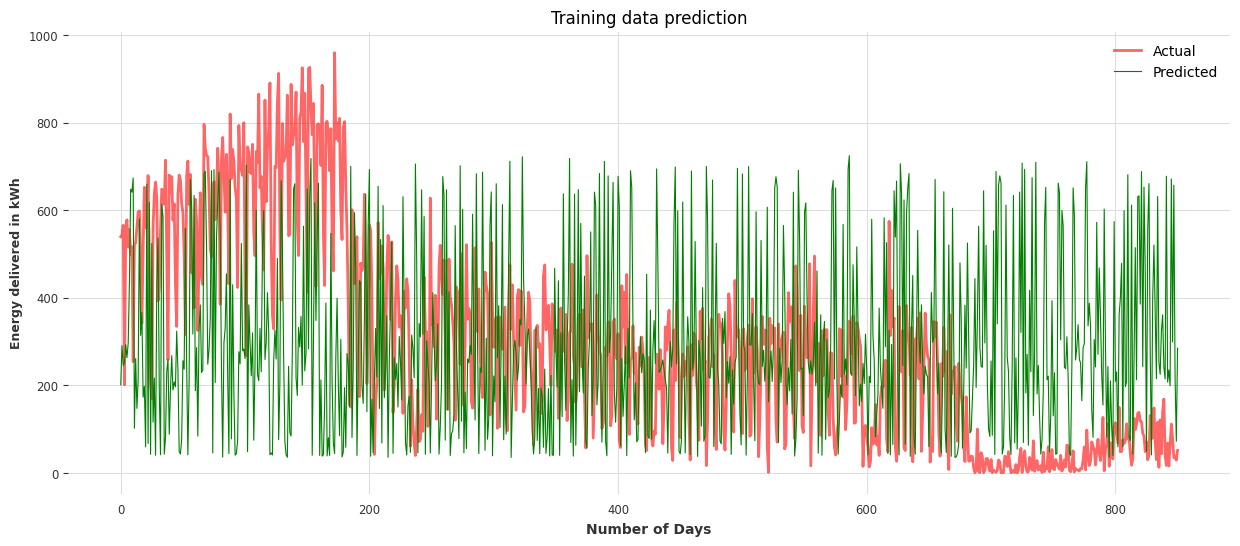

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(temp, actual, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(temp, predictions, color = 'green', linewidth=0.8)
plt.legend(['Actual','Predicted'],loc='upper right')
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh', fontsize=9)
plt.title("Training data prediction")
plt.show()

In [ ]:
plt.plot(actual, label='Actual Value')
plt.plot(predictions, label='Predicted Value')
plt.title('Actual vs Predicted Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def testgenerateloader(SEQUENCE_SIZE,BATCH_SIZE,n_days):
  x_test, y_test = to_sequences(SEQUENCE_SIZE, caltech_train[:n_days])
  test_dataset = TensorDataset(x_test, y_test)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
  return test_loader,x_test,y_test

Prediction for 30 days


In [ ]:
test_loader,x_test,y_test=testgenerateloader(8,128,38)

In [ ]:
test_loader

In [ ]:
predictions=evaluate(model,test_loader)
len(predictions)

30

In [ ]:
actual=scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

In [ ]:
predictions=scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [ ]:
predicted=predictions[:,0]
actual=actual[:,0]
create_dataset(actual,predicted,"caltech_30days.csv")

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predictions,actual,squared=False)

138.1487550322183

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,actual)

101.63536265381582

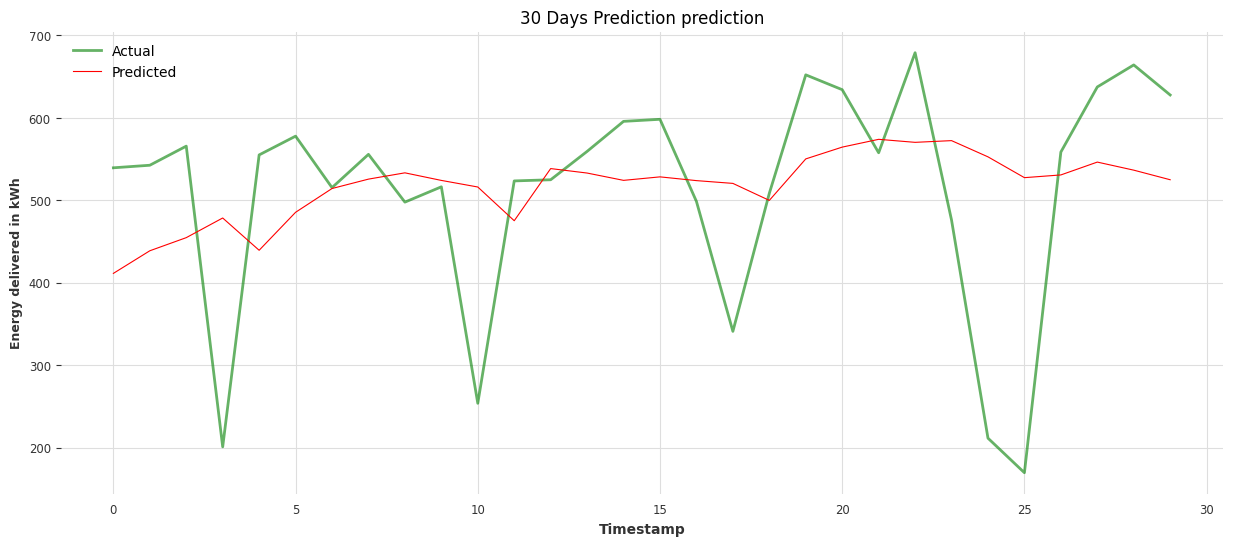

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(actual, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(predictions, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.ylabel('Energy delivered in kWh', fontsize=9)
plt.title("30 Days Prediction prediction")
plt.show()

Prediction 120 Days

In [ ]:
test_loader,x_test,y_test=testgenerateloader(8,128,128)

In [ ]:
predictions=evaluate(model,test_loader)
len(predictions)

120

In [ ]:
actual=scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

In [ ]:
predictions=scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [ ]:
predicted=predictions[:,0]
actual=actual[:,0]
create_dataset(actual,predicted,"caltech_120days.csv")

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,actual)

99.82533048119458

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predictions,actual,squared=False)

127.53193106950715

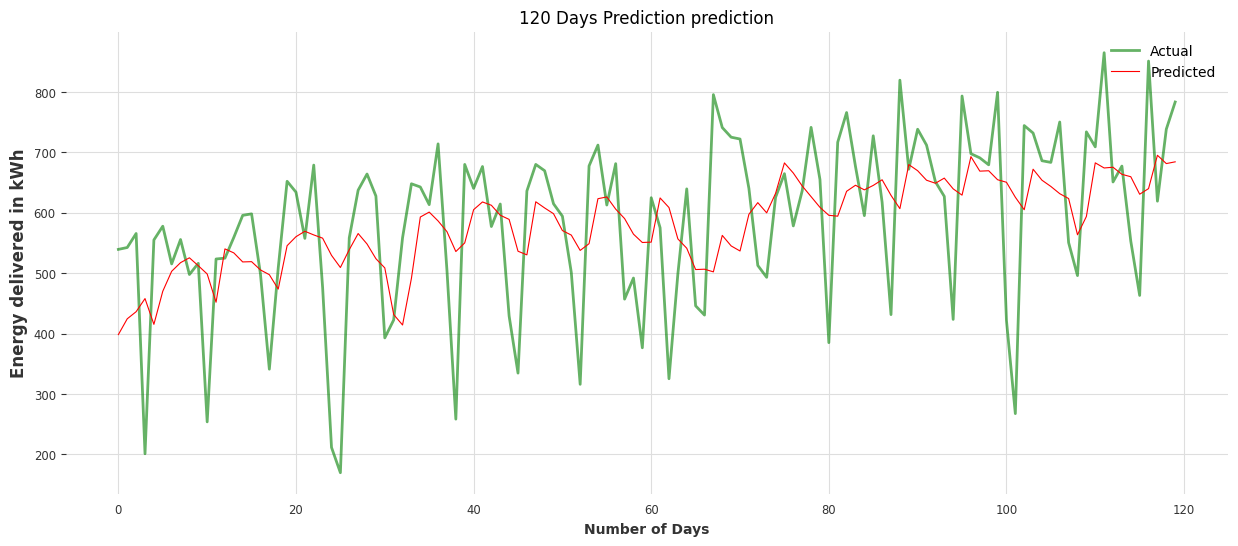

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(actual, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(predictions, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'],loc='upper right')
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh', fontsize=12)
plt.title("120 Days Prediction prediction")
plt.show()

Prediction 200+Days

In [ ]:
test_loader,x_test,y_test=testgenerateloader(8,128,258)

In [ ]:
predictions=evaluate(model,test_loader)
len(predictions)

250

In [ ]:
actual=scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

In [ ]:
predictions=scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [ ]:
predicted=predictions[:,0]
actual=actual[:,0]
create_dataset(actual,predicted,"caltech_200days.csv")

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,actual)

119.24630955761397

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predictions,actual,squared=False)

151.19752263089697

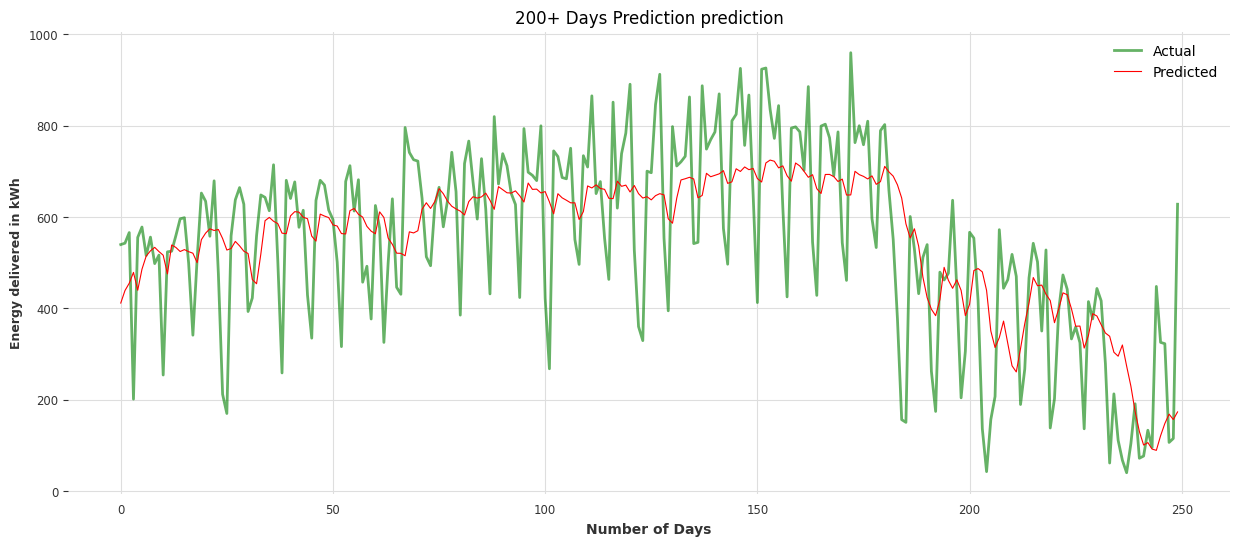

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(actual, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(predictions, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh', fontsize=9)
plt.title("200+ Days Prediction prediction")
plt.show()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'SVM':75.65, 'XGBoost': 87.65 ,'LSTM':68.809
, 'N-Beats':67.2819,
        'Transformer': 81.781}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values,
        width = 0.4)

plt.xlabel("Model")
plt.ylabel("Mean Absolute Error (kwh)")
plt.title("Comparison of Models")
plt.show()


In [ ]:
data = {'SVM': 75.65, 'XGBoost': 87.65, 'LSTM': 68.809, 'N-Beats': 67.2819, 'Transformer': 81.781}
courses = list(data.keys())
values = list(data.values())

# Create the line plot
plt.plot(courses, values, marker='o', linestyle='-')

plt.xlabel("Model")
plt.ylabel("Mean Absolute Error (kwh)")
plt.title("Comparison of Models")
plt.grid(True)
plt.show()

### LSTM JPL

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
df_train=jpl[jpl["Date"]<"2021-02-01"]
df_test=jpl[jpl["Date"]>="2021-02-01"]

In [ ]:
df_train.shape,df_test.shape

((742, 2), (214, 2))

In [ ]:


torch.cuda.empty_cache()



In [ ]:
jpl_train = df_train['Power'].to_numpy().reshape(-1, 1)
jpl_test = df_test['Power'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
jpl_train = scaler.fit_transform(jpl_train).flatten().tolist()
jpl_test = scaler.transform(jpl_test).flatten().tolist()

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64, 32)
        self.fc2=nn.Linear(32,1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
def train(model,epochs,train_loader):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)
  early_stop_count = 0
  min_val_loss = float('inf')
  arr=[]
  for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in train_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")
  return loss

In [ ]:
def evaluate(model,temp):
  model.eval()
  predictions = []
  with torch.no_grad():
      for batch in temp:
          x_batch, y_batch = batch
          x_batch = x_batch.to(device)
          outputs = model(x_batch)
          predictions.extend(outputs.squeeze().tolist())
  predictions
  return predictions

In [ ]:
def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [ ]:
def generateloader(SEQUENCE_SIZE,BATCH_SIZE):
  x_train, y_train = to_sequences(SEQUENCE_SIZE, caltech_train)
  x_test, y_test = to_sequences(SEQUENCE_SIZE, caltech_test)
  train_dataset = TensorDataset(x_train, y_train)
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

  test_dataset = TensorDataset(x_test, y_test)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
  return test_loader,train_loader,x_train, y_train ,x_test,y_test

In [ ]:
def plot_loss(validation_loss):
  epochs = range(1, len(validation_loss) + 1)
  plt.plot(epochs, validation_loss, marker='o', label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Validation Loss')
  plt.title('Validation Loss vs Epoch Curve')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
model = LSTMModel().to(device)

In [ ]:
test_loader,train_loader,x_train, y_train ,x_test,y_test=generateloader(8,128)

In [ ]:
loss=train(model,100,train_loader)

Epoch 1/100, Validation Loss: 0.9005
Epoch 2/100, Validation Loss: 0.7499
Epoch 3/100, Validation Loss: 0.5032
Epoch 4/100, Validation Loss: 0.2895
Epoch 5/100, Validation Loss: 0.3119
Epoch 6/100, Validation Loss: 0.2710
Epoch 7/100, Validation Loss: 0.2746
Epoch 8/100, Validation Loss: 0.2620
Epoch 9/100, Validation Loss: 0.2658
Epoch 10/100, Validation Loss: 0.2595
Epoch 11/100, Validation Loss: 0.2594
Epoch 12/100, Validation Loss: 0.2570
Epoch 13/100, Validation Loss: 0.2597
Epoch 14/100, Validation Loss: 0.2567
Epoch 15/100, Validation Loss: 0.2584
Epoch 16/100, Validation Loss: 0.2514
Epoch 17/100, Validation Loss: 0.2525
Epoch 18/100, Validation Loss: 0.2470
Epoch 19/100, Validation Loss: 0.2504
Epoch 20/100, Validation Loss: 0.2502
Epoch 21/100, Validation Loss: 0.2491
Epoch 00022: reducing learning rate of group 0 to 5.0000e-04.
Epoch 22/100, Validation Loss: 0.2498
Early stopping!
Epoch 23/100, Validation Loss: 0.2470
Early stopping!
Epoch 24/100, Validation Loss: 0.2525
Ear

In [ ]:
predictions=evaluate(model,train_loader)

In [ ]:
actual=scaler.inverse_transform(np.array(y_train).reshape(-1, 1))
len(actual)

851

In [ ]:
predictions=scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
len(predictions)

851

In [ ]:
predicted=predictions[:,0]
actual=actual[:,0]
create_dataset(actual,predicted,"jpl_train.csv")

In [ ]:
predictions[:5],actual[:5]

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predictions,actual,squared=False)

604.0213263110596

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,actual)

479.8100972046994

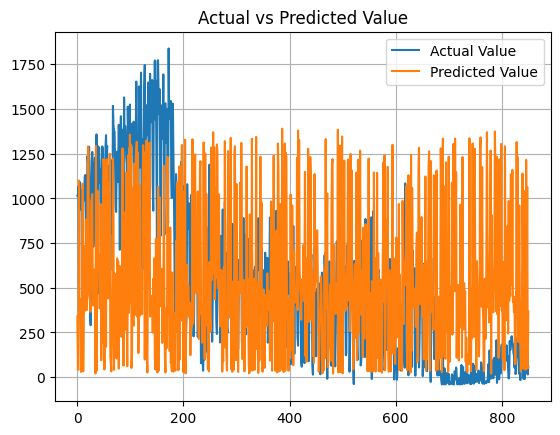

In [ ]:
plt.plot(actual, label='Actual Value')
plt.plot(predictions, label='Predicted Value')
plt.title('Actual vs Predicted Value')
plt.legend()
plt.grid(True)
plt.show()

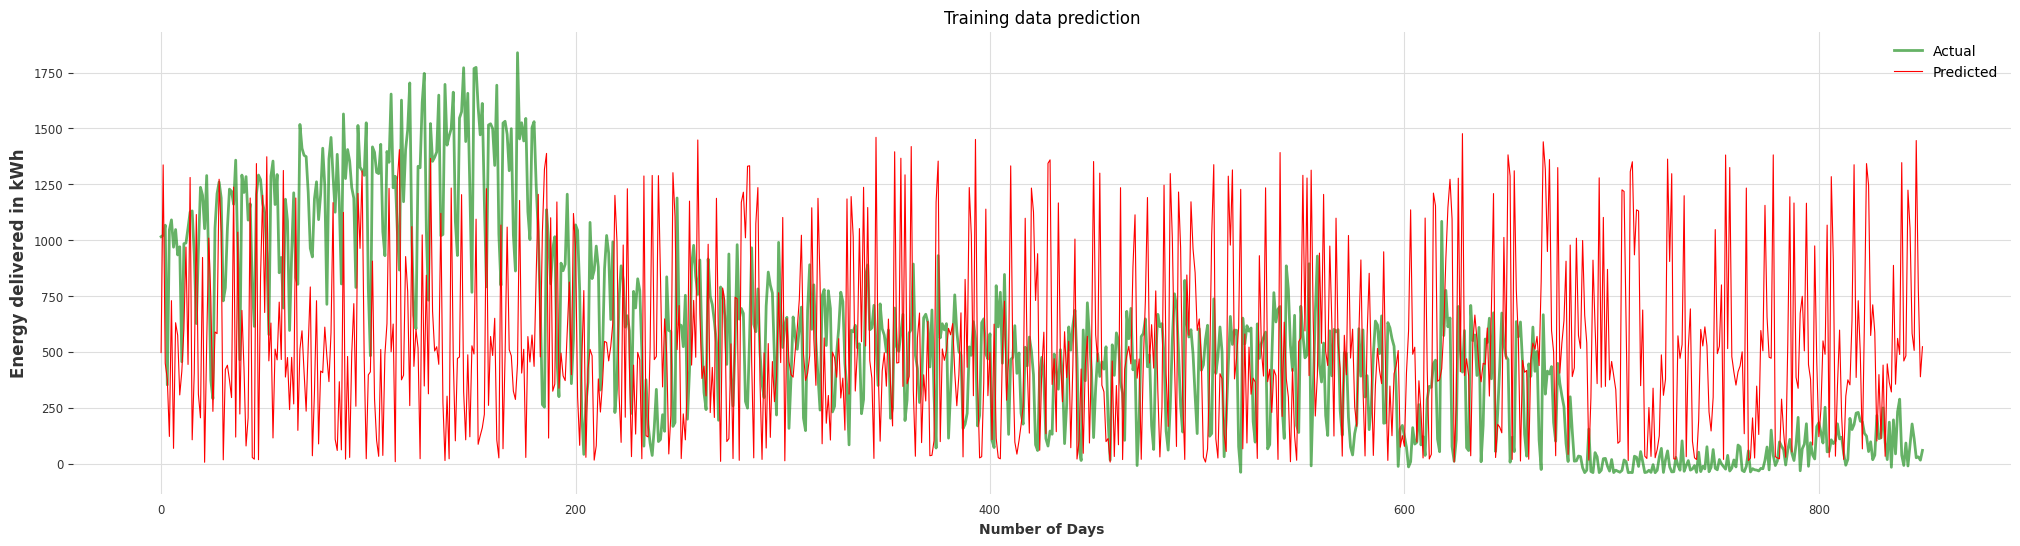

In [ ]:
plt.figure(figsize=(25,6))
plt.plot(actual, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(predictions, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh', fontsize=12)
plt.title("Training data prediction")
plt.show()

 Custom test generator

In [ ]:
def testgenerateloader(SEQUENCE_SIZE,BATCH_SIZE,n_days):
  x_test, y_test = to_sequences(SEQUENCE_SIZE, caltech_train[:n_days])
  test_dataset = TensorDataset(x_test, y_test)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
  return test_loader,x_test,y_test

Prediction for 30 days


In [ ]:
test_loader,x_test,y_test=testgenerateloader(8,128,38)

In [ ]:
test_loader

In [ ]:
predictions=evaluate(model,test_loader)
len(predictions)

30

In [ ]:
actual=scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

In [ ]:
predictions=scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [ ]:
predicted=predictions[:,0]
actual=actual[:,0]
create_dataset(actual,predicted,"jpl_30days.csv")

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predictions,actual,squared=False)

255.47911825744214

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,actual)

196.6894737058279

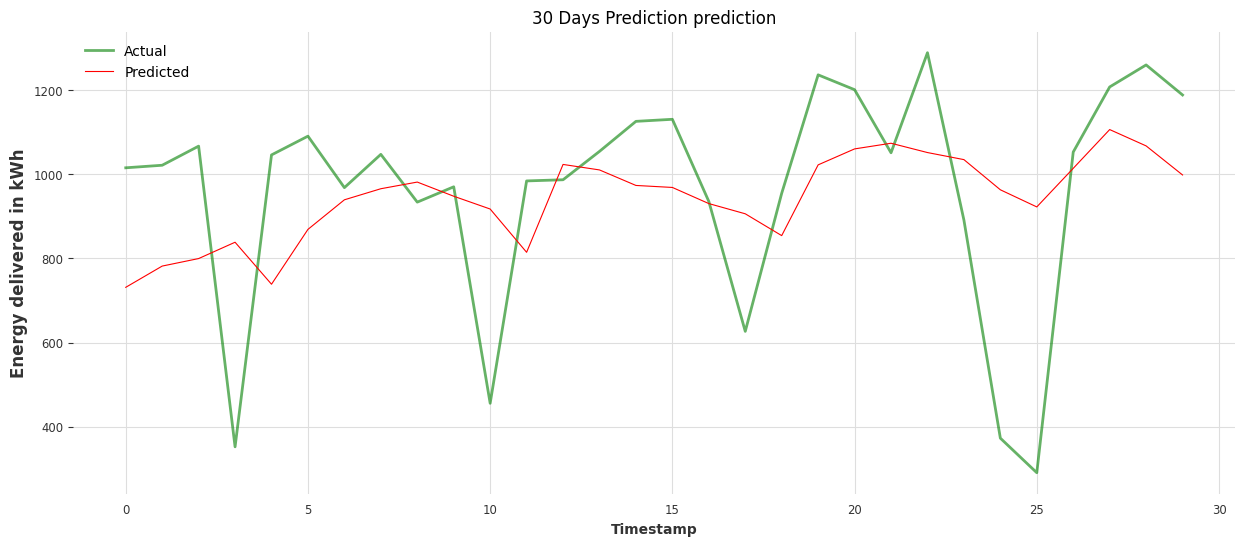

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(actual, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(predictions, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.ylabel('Energy delivered in kWh', fontsize=12)
plt.title("30 Days Prediction prediction")
plt.show()

Prediction 120 Days

In [ ]:
test_loader,x_test,y_test=testgenerateloader(8,128,128)

In [ ]:
predictions=evaluate(model,test_loader)
len(predictions)

120

In [ ]:
actual=scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

In [ ]:
predictions=scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [ ]:
predicted=predictions[:,0]
actual=actual[:,0]
create_dataset(actual,predicted,"jpl_120days.csv")

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,actual)

193.16484793917127

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predictions,actual,squared=False)

246.33281024412858

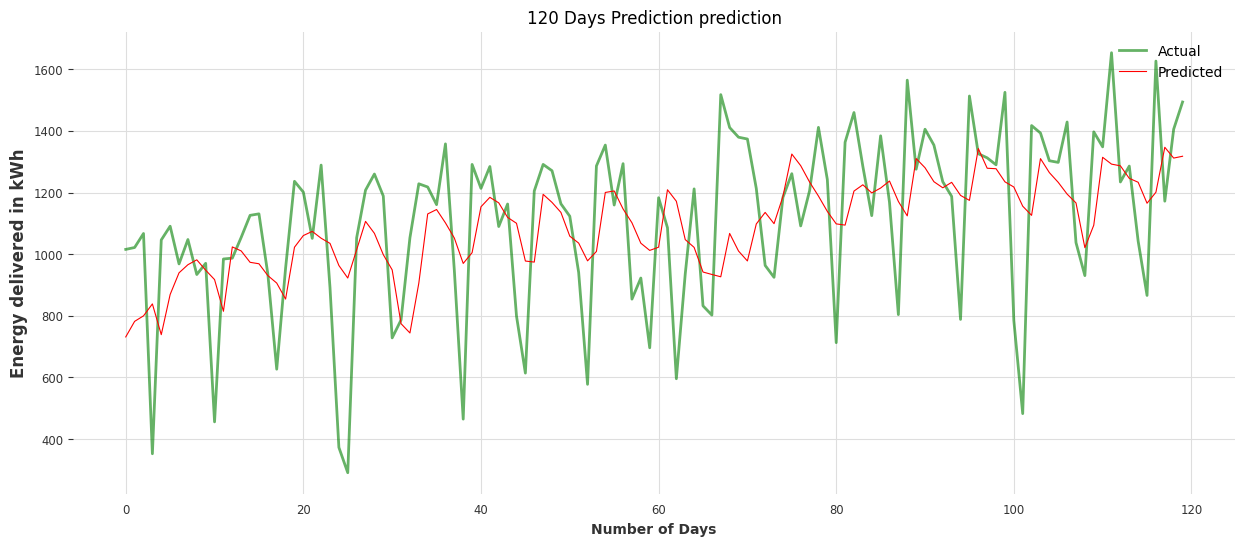

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(actual, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(predictions, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'],loc='upper right')
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh', fontsize=12)
plt.title("120 Days Prediction prediction")
plt.show()

Prediction 200+Days

In [ ]:
test_loader,x_test,y_test=testgenerateloader(8,128,258)

In [ ]:
predictions=evaluate(model,test_loader)
len(predictions)

250

In [ ]:
actual=scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

In [ ]:
predictions=scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [ ]:
predicted=predictions[:,0]
actual=actual[:,0]
create_dataset(actual,predicted,"jpl_200days.csv")

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions,actual)

222.69844051490324

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predictions,actual,squared=False)

286.9146337010731

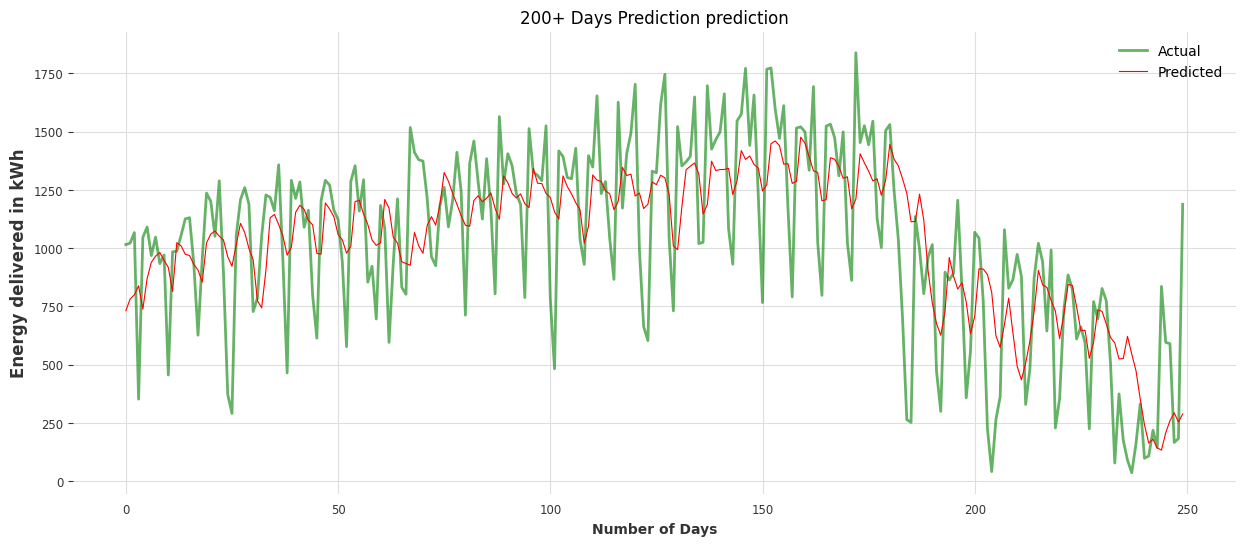

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(actual, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(predictions, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh', fontsize=12)
plt.title("200+ Days Prediction prediction")
plt.show()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'SVM':75.65, 'XGBoost': 87.65 ,'LSTM':68.809
, 'N-Beats':67.2819,
        'Transformer': 81.781}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values,
        width = 0.4)

plt.xlabel("Model")
plt.ylabel("Mean Absolute Error (kwh)")
plt.title("Comparison of Models")
plt.show()


In [ ]:
data = {'SVM': 75.65, 'XGBoost': 87.65, 'LSTM': 68.809, 'N-Beats': 67.2819, 'Transformer': 81.781}
courses = list(data.keys())
values = list(data.values())

# Create the line plot
plt.plot(courses, values, marker='o', linestyle='-')

plt.xlabel("Model")
plt.ylabel("Mean Absolute Error (kwh)")
plt.title("Comparison of Models")
plt.grid(True)
plt.show()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'SVM':75.65, 'XGBoost': 87.65 ,'LSTM':68.809
, 'N-Beats':67.2819,
        'Transformer': 81.781}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values,
        width = 0.4)

plt.xlabel("Model")
plt.ylabel("Mean Absolute Error (kwh)")
plt.title("Comparison of Models")
plt.show()


In [ ]:
data = {'SVM': 75.65, 'XGBoost': 87.65, 'LSTM': 68.809, 'N-Beats': 67.2819, 'Transformer': 81.781}
courses = list(data.keys())
values = list(data.values())

# Create the line plot
plt.plot(courses, values, marker='o', linestyle='-')

plt.xlabel("Model")
plt.ylabel("Mean Absolute Error (kwh)")
plt.title("Comparison of Models")
plt.grid(True)
plt.show()

##Transformers using Darts for Caltech


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score

In [ ]:
from darts.models import TransformerModel, ExponentialSmoothing
from darts.dataprocessing.transformers import MissingValuesFiller

In [ ]:
series_caltech = TimeSeries.from_dataframe(caltech,'Date',value_cols=['Power'],fill_missing_dates=True,freq="D")

In [ ]:
filler=MissingValuesFiller()
scaler = Scaler()

In [ ]:
series_caltech=filler.transform(series_caltech)

In [ ]:
train, test = series_caltech.split_after(pd.Timestamp("20210101"))

In [ ]:
len(train.all_values()),len(test.all_values())

(983, 256)

In [ ]:
train_scaled = scaler.fit_transform(train)
test_scaled=scaler.transform(test)
series_scaled = scaler.transform(series_caltech)

In [ ]:
model = TransformerModel(
    input_chunk_length=256,
    output_chunk_length=10,
    batch_size=8,
    d_model=64,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    save_checkpoints=True,
    force_reset=True,
    optimizer_kwargs={"lr": 1e-3}
)

In [ ]:
model.fit(train_scaled,epochs=20)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


TransformerModel(d_model=64, nhead=8, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=128, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=256, output_chunk_length=10, batch_size=8, save_checkpoints=True, force_reset=True, optimizer_kwargs={'lr': 0.001})

###Training data prediction

In [ ]:
pred=model.historical_forecasts(train_scaled,retrain=False)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
pred=scaler.inverse_transform(pred)
pred=pred.all_values()[:,0]
pred=pred[:,0]

In [ ]:
actual=train.all_values()[:,0]
actual=actual[:,0]
actual=actual[len(actual)-len(pred):]

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(pred,actual,squared=False)

78.13687444812304

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(pred,actual)

56.03838428717916

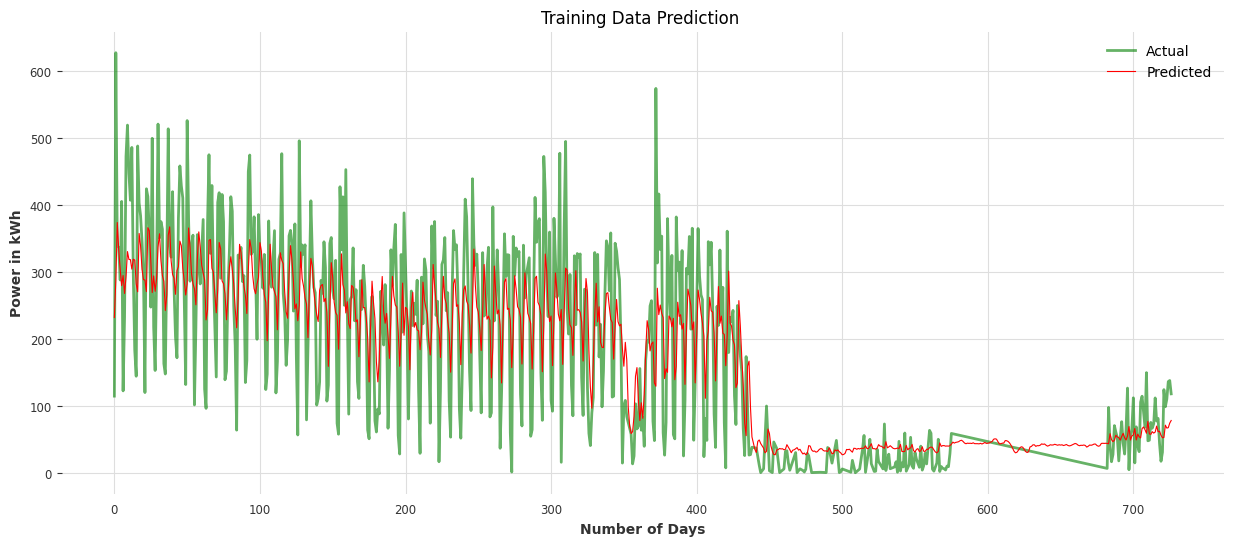

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(actual, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(pred, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.title("Training Data Prediction ")
plt.ylabel("Power in kWh")
plt.show()

###30 days Prediction

In [ ]:
scaled_pred = model.predict(n=30)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
scaled_pred=scaler.inverse_transform(scaled_pred)

In [ ]:
scaled_pred=concatenate(scaled_pred)

In [ ]:
predicted=scaled_pred.all_values()[:,0]

In [ ]:
predicted=predicted[:,0]
predicted=abs(predicted)

In [ ]:
actual=test.all_values()[:,0]
actual=actual[:,0]
actual=actual[:30]

In [ ]:
len(actual),len(predicted)

(30, 30)

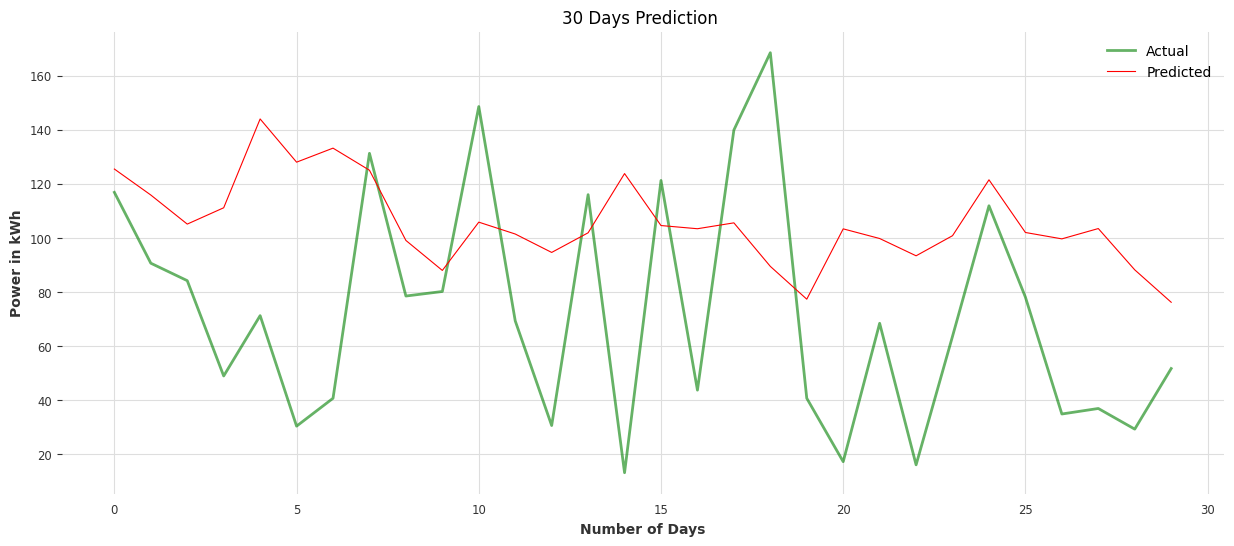

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(actual, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(predicted+50, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.title("30 Days Prediction ")
plt.ylabel("Power in kWh")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predicted,actual)

37.61839413935729

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predicted,actual,squared=False)

46.64681399415719

###120 days Prediction

In [ ]:
scaled_pred = model.predict(n=120)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
scaled_pred=scaler.inverse_transform(scaled_pred)

In [ ]:
scaled_pred=concatenate(scaled_pred)

In [ ]:
predicted=scaled_pred.all_values()[:,0]

In [ ]:
predicted=predicted[:,0]
predicted=abs(predicted)

In [ ]:
actual=test.all_values()[:,0]
actual=actual[:,0]
actual=actual[:120]

In [ ]:
len(actual),len(predicted)

(120, 120)

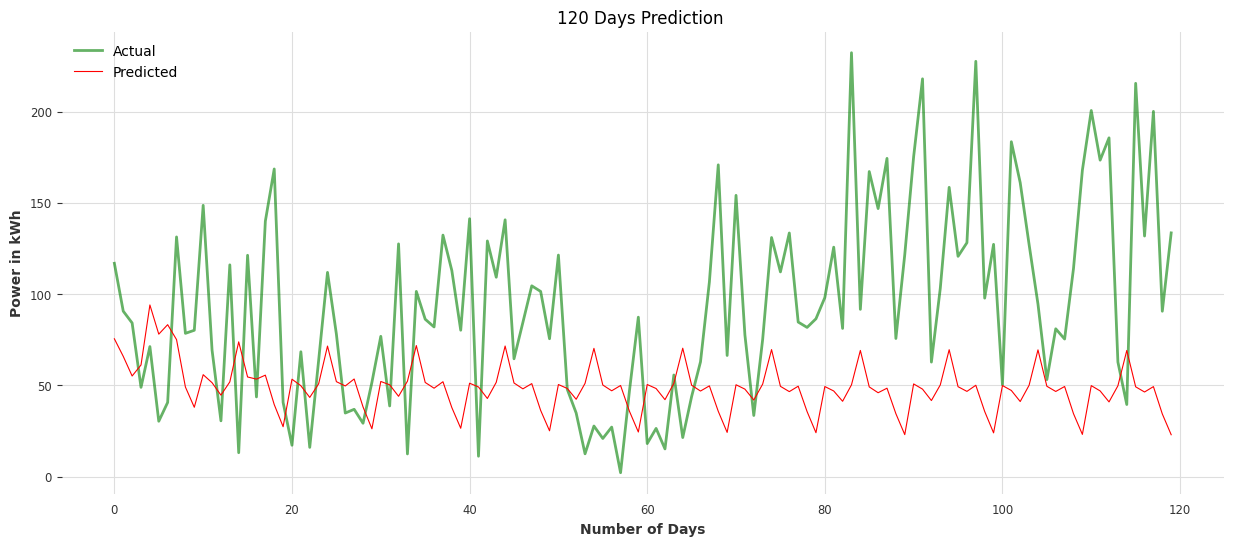

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(actual, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(predicted, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.title("120 Days Prediction ")
plt.ylabel("Power in kWh")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predicted,actual)

57.41639581002827

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predicted,actual,squared=False)

71.8325948176485

## LSTM

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
%matplotlib inline

In [ ]:
y=jpl['Power']

In [ ]:
y.shape

(956,)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# scale of the output and input inthe range 0-1 to match the scale of the layer of LSTM
scaler = MinMaxScaler(feature_range = (0,1))
# reshape: convert the univariate 1D array into 2D
y = scaler.fit_transform(np.array(y).reshape(-1,1))
print("Normalizing data before model fitting")
print(y[:10])

Normalizing data before model fitting
[[0.18766961]
 [0.33836761]
 [0.35456011]
 [0.03621462]
 [0.01566115]
 [0.45507191]
 [0.01445751]
 [0.30941948]
 [0.21929531]
 [0.01297125]]


In [ ]:
training_size = int(len(y)*0.60)
test_size = len(y)- training_size
val_size = int(training_size*0.20)
train_data , test_data , val_data = y[0:training_size-val_size,:] , y[training_size:len(y),:1], y[len(y)-test_size-val_size:len(y)-test_size,:1]


In [ ]:
def create_dataset(dataset, time_step = 1):
  dataX, dataY = [] , []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
X_val, yval = create_dataset(val_data, time_step)


In [ ]:
# reshape train and input-output pairs
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)

X_train shape:  (358, 100, 1)
X_test shape:  (282, 100, 1)
X_val shape:  (13, 100, 1)


In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (time_step, 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# # Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
# model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_val,yval), verbose = 1,epochs = 60 ,batch_size = 20)

Epoch 1/60
18/18 [==============================] - 21s 573ms/step - loss: 0.2052 - val_loss: 0.0464
Epoch 2/60
18/18 [==============================] - 5s 261ms/step - loss: 0.1378 - val_loss: 0.0977
Epoch 3/60
18/18 [==============================] - 5s 295ms/step - loss: 0.1335 - val_loss: 0.1642
Epoch 4/60
18/18 [==============================] - 7s 384ms/step - loss: 0.1307 - val_loss: 0.1641
Epoch 5/60
18/18 [==============================] - 7s 374ms/step - loss: 0.1293 - val_loss: 0.1139
Epoch 6/60
18/18 [==============================] - 4s 205ms/step - loss: 0.1322 - val_loss: 0.1656
Epoch 7/60
18/18 [==============================] - 3s 186ms/step - loss: 0.1302 - val_loss: 0.1244
Epoch 8/60
18/18 [==============================] - 5s 301ms/step - loss: 0.1333 - val_loss: 0.1122
Epoch 9/60
18/18 [==============================] - 4s 224ms/step - loss: 0.1329 - val_loss: 0.1154
Epoch 10/60
18/18 [==============================] - 3s 179ms/step - loss: 0.1356 - val_loss: 0.105

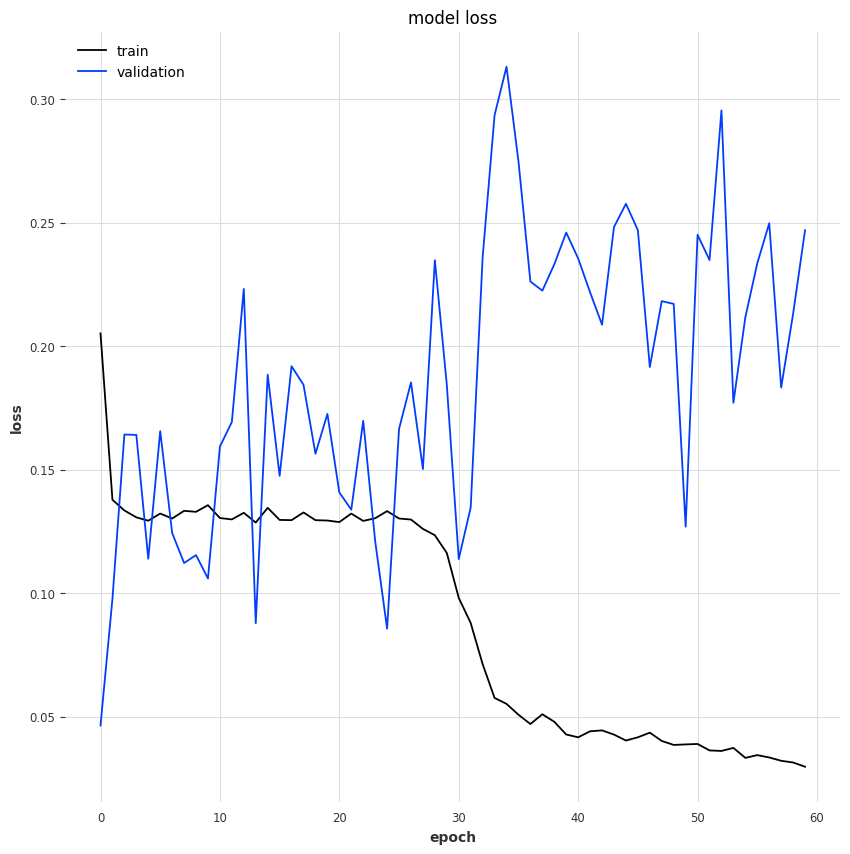

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
val_predict=model.predict(X_val)

1/1 [==============================] - 0s 65ms/step


In [ ]:
X_train[:30]

In [ ]:
len(ytest)

282

In [ ]:
y_30=model.predict(X_train[:120])

4/4 [==============================] - 0s 41ms/step


In [ ]:
y_30=scaler.inverse_transform(y_30)
y_actual=scaler.inverse_transform(ytest[:120].reshape(-1,1))

In [ ]:
y_30

array([[ 102.82881 ],
       [ 171.35724 ],
       [ 952.8303  ],
       [ 919.20276 ],
       [ 880.0365  ],
       [ 759.23724 ],
       [ 370.95776 ],
       [ -29.6137  ],
       [ 148.80658 ],
       [ 852.9207  ],
       [ 887.01385 ],
       [ 748.05804 ],
       [ 489.19843 ],
       [ 331.40753 ],
       [ 248.78065 ],
       [ 303.66544 ],
       [ 354.90393 ],
       [ 314.32834 ],
       [ 163.4872  ],
       [  13.521548],
       [ 606.511   ],
       [ 974.58154 ],
       [1021.12537 ],
       [1050.5378  ],
       [ 883.9616  ],
       [ 143.0048  ],
       [ -14.946002],
       [1036.5548  ],
       [ 881.9911  ],
       [ 911.8113  ]], dtype=float32)

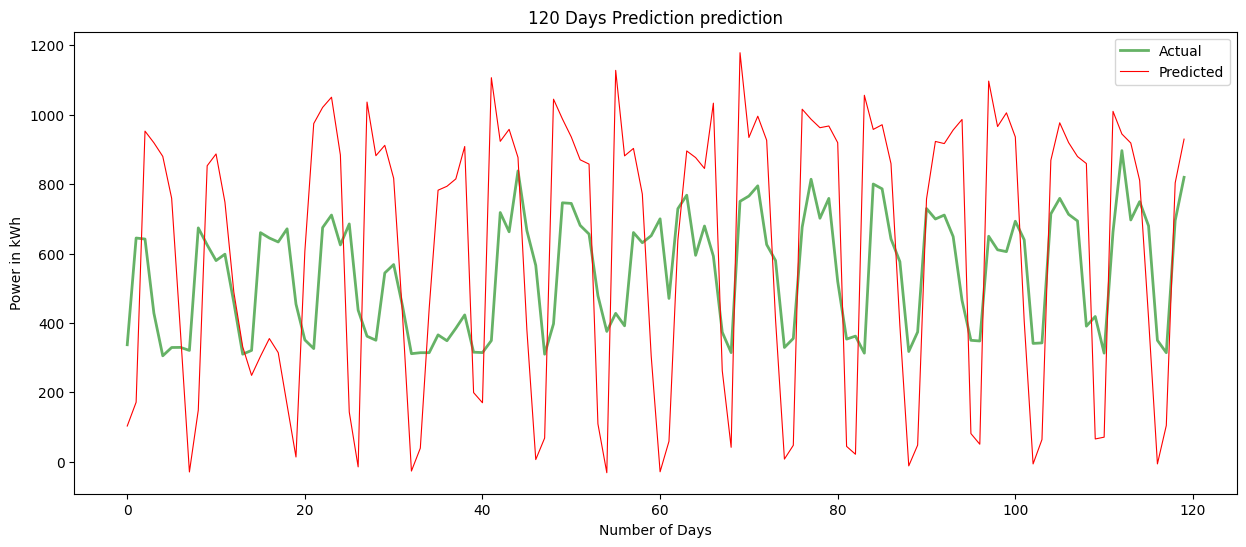

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(y_actual+300, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(y_30, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.title("120 Days Prediction prediction")
plt.ylabel("Power in kWh")
plt.show()

In [ ]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
val_predict=scaler.inverse_transform(val_predict)

In [ ]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

791.5875091785632

In [ ]:
train_predictions = model.predict(X_train)
train_predictions =scaler.inverse_transform(train_predictions)

y_train = y_train.reshape(y_train.shape[0], 1)
actual = scaler.inverse_transform(y_train)
train_results = pd.DataFrame()

train_results["Train Predictions"] = train_predictions.tolist()
train_results["Actuals"] = actual.tolist()

train_results

12/12 [==============================] - 1s 65ms/step


Train Predictions               Actuals
0      [222.274169921875]              [78.926]
1    [-37.50977325439453]               [26.04]
2      [893.056396484375]             [877.541]
3        [836.5419921875]   [972.4099999999999]
4     [903.2371215820312]             [899.896]
..                    ...                   ...
353   [76.00969696044922]              [66.368]
354   [1138.646728515625]             [1065.97]
355  [1042.1541748046875]            [1079.526]
356   [1038.663330078125]  [1230.2941511111112]
357     [940.25830078125]            [1079.794]

[358 rows x 2 columns]

In [ ]:
plt.figure(figsize=(15,6))

# Actual Consumption
ActualPlot = np.empty_like(y )
ActualPlot[:, :] = np.nan
ActualPlot[358:, :] = actual.tolist()
plt.plot(ActualPlot)

TrainPredictionsPlot = np.empty_like(y )
TrainPredictionsPlot[:, :] = np.nan
TrainPredictionsPlot[598:, :] = train_predictions.tolist()
plt.plot(TrainPredictionsPlot)

plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh', fontsize=9)
plt.show()

ValueError: ignored

<Figure size 1500x600 with 0 Axes>

In [ ]:
math.sqrt(mean_squared_error(y_train, train_predict))

359.1076165861386

In [ ]:
math.sqrt(mean_squared_error(y_test, test_predict))

214.4481340306031

## N Beats Caltech


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score

In [ ]:
series_caltech = TimeSeries.from_dataframe(caltech,'Date',value_cols=['Power'],fill_missing_dates=True,freq="D")

In [ ]:
filler=MissingValuesFiller()
scaler = Scaler()


In [ ]:
series=filler.transform(series_caltech)

In [ ]:
train, test = series.split_after(pd.Timestamp("20201201"))

In [ ]:
val,arr=test.split_after(pd.Timestamp("20210301"))

In [ ]:
len(train.all_values()),len(val.all_values()),len(test.all_values())

(952, 90, 287)

In [ ]:
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled=scaler.transform(test)
series_scaled = scaler.transform(series)

Text(0.5, 1.0, 'Training, Validation and Test Dataset')

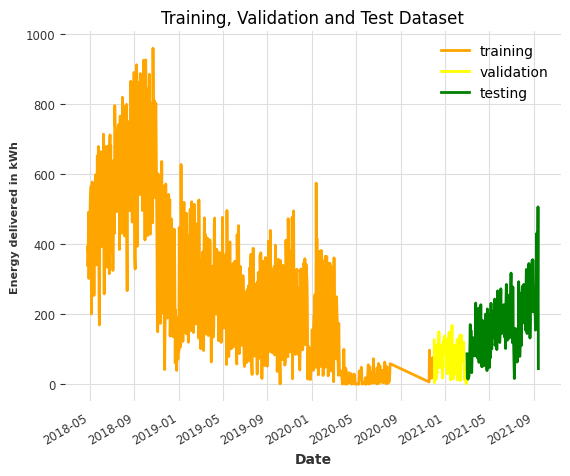

In [ ]:
train.plot(label="training",color='orange')
val.plot(label="validation",color="yellow")
arr.plot(label="testing",color="green")
plt.ylabel('Energy delivered in kWh', fontsize=8)

plt.title("Training, Validation and Test Dataset")

In [ ]:
nbeats = NBEATSModel(
    input_chunk_length=256,
    output_chunk_length=10,
    generic_architecture=True)

nbeats.fit(
    train_scaled,
    epochs=50
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.0 M 
---------------------------------------------------
8.0 M     Trainable params
2.8 K     Non-trainable params
8.0 M     Total params
32.080    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=256, output_chunk_length=10)

In [ ]:
# nbeats = NBEATSModel(
#     input_chunk_length=256,
#     output_chunk_length=1,
#     generic_architecture=True,
#     num_stacks=30,
#     num_blocks=1,
#     num_layers=4,
#     n_epochs=1000,
#     dropout=0.2,
#     force_reset=True,
# )

In [ ]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None,pred_start_date=None):
    plt.figure(figsize=(8, 5))
    if pred_start_date:
      pred_series = pred_series.drop_before(pred_start_date)
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    (ts_transformed.univariate_component(0)).plot(label="actual",color="orange")
    (pred_series).plot(label=("Forecast"),color="yellow")
    plt.title(
        "120 Days Prediction"
    )
    plt.legend()

In [ ]:
# display_forecast(
#     scaled_pred_nbeats,
#     val,
#     "Forecast on Testing data",
#     start_date=test.start_time(),
# )

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(y_actual+300, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(y_30, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.title("120 Days Prediction prediction")
plt.ylabel("Power in kWh")
plt.show()

NameError: ignored

<Figure size 1500x600 with 0 Axes>

120 days Prediction

In [ ]:
scaled_pred_nbeats = nbeats.predict(n=120)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
scaled_pred_nbeats=scaler.inverse_transform(scaled_pred_nbeats)

In [ ]:
scaled_pred_nbeats=concatenate(scaled_pred_nbeats)

In [ ]:
predicted=scaled_pred_nbeats.all_values()[:,0]

In [ ]:
predicted=predicted[:,0]

In [ ]:
predicted=abs(predicted)

In [ ]:
actual=test.all_values()[:,0]
actual=actual[:,0]
actual=actual[:120]

In [ ]:
len(actual),len(predicted)

(120, 120)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predicted,actual)

50.94054538292747

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predicted,actual,squared=False)

63.7439778031835

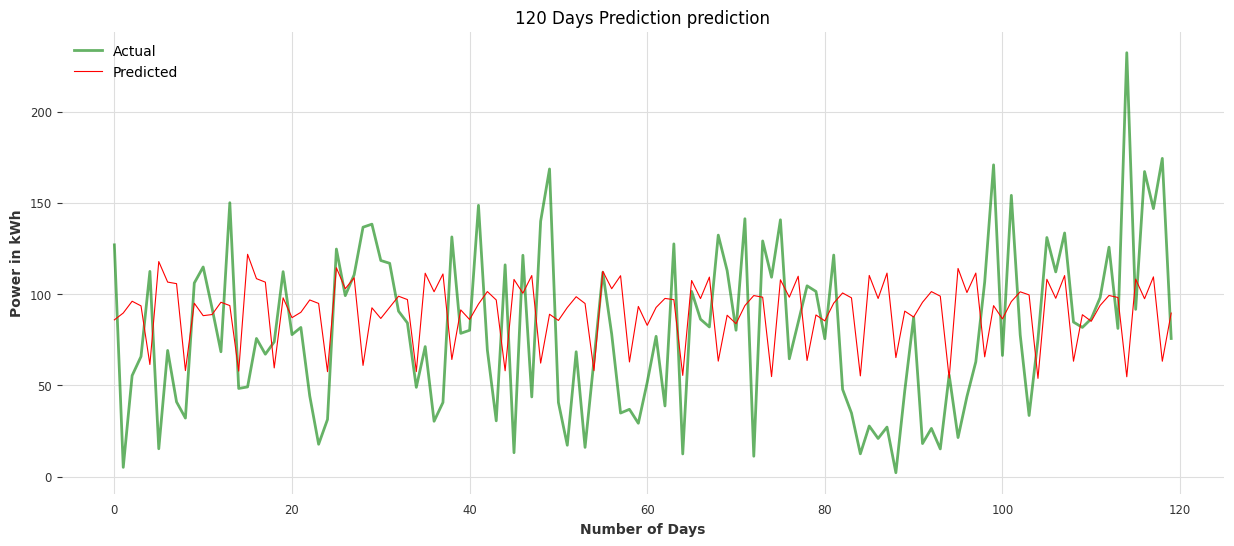

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(actual, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(predicted+50, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.title("120 Days Prediction prediction")
plt.ylabel("Power in kWh")
plt.show()

200 days prediction

In [ ]:
scaled_pred_nbeats = nbeats.predict(n=250)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
scaled_pred_nbeats=scaler.inverse_transform(scaled_pred_nbeats)

In [ ]:
scaled_pred_nbeats=concatenate(scaled_pred_nbeats)

In [ ]:
predicted=scaled_pred_nbeats.all_values()[:,0]

In [ ]:
predicted=predicted[:,0]

In [ ]:
predicted=abs(predicted)

In [ ]:
actual=test.all_values()[:,0]
actual=actual[:,0]
actual=actual[:250]

In [ ]:
len(actual),len(predicted)

(250, 250)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predicted,actual)

89.56975619819889

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predicted,actual,squared=False)

110.77544225473187

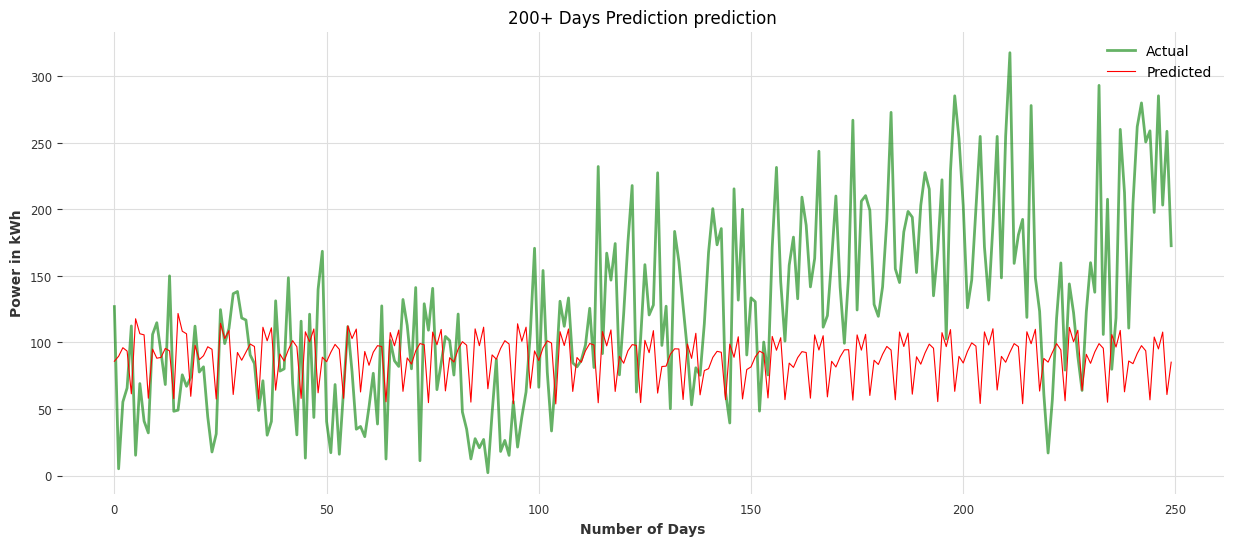

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(actual, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(predicted+50, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.title("200+ Days Prediction prediction")
plt.ylabel("Power in kWh")
plt.show()

## N Beats JPL


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score

In [ ]:
series_jpl = TimeSeries.from_dataframe(jpl,'Date',value_cols=['Power'],fill_missing_dates=True,freq="D")

In [ ]:
filler=MissingValuesFiller()
scaler = Scaler()


In [ ]:
series=filler.transform(series_jpl)

In [ ]:
train, test = series.split_after(pd.Timestamp("20201201"))

In [ ]:
val,arr=test.split_after(pd.Timestamp("20210301"))

In [ ]:
len(train.all_values()),len(val.all_values()),len(test.all_values())

(819, 90, 287)

In [ ]:
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled=scaler.transform(test)
series_scaled = scaler.transform(series)

<Figure size 5000x2100 with 0 Axes>

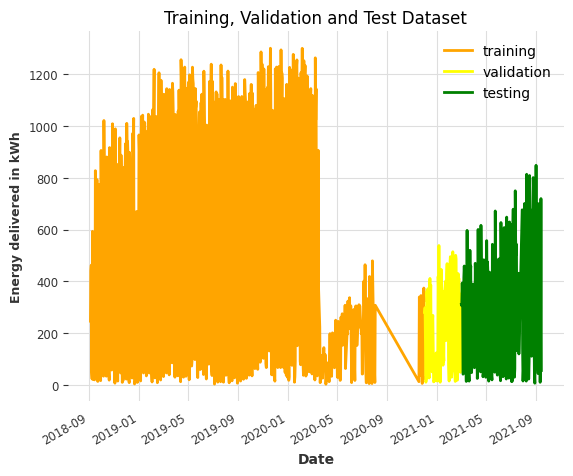

<Figure size 5000x2100 with 0 Axes>

In [ ]:
train.plot(label="training",color='orange')
val.plot(label="validation",color="yellow")
arr.plot(label="testing",color="green")
plt.title("Training, Validation and Test Dataset")
plt.ylabel('Energy delivered in kWh', fontsize=9)
plt.figure(figsize=(50,21))

In [ ]:
nbeats = NBEATSModel(
    input_chunk_length=256,
    output_chunk_length=10,
    generic_architecture=True)

In [ ]:
nbeats.fit(
    train_scaled,
    epochs=50
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.0 M 
---------------------------------------------------
8.0 M     Trainable params
2.8 K     Non-trainable params
8.0 M     Total params
32.080    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=256, output_chunk_length=10)

In [ ]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None,pred_start_date=None):
    plt.figure(figsize=(8, 5))
    if pred_start_date:
      pred_series = pred_series.drop_before(pred_start_date)
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    (ts_transformed.univariate_component(0)).plot(label="actual",color="orange")
    (pred_series).plot(label=("Forecast"),color="yellow")
    plt.title(
        "120 Days Prediction"
    )
    plt.legend()

In [ ]:
# display_forecast(
#     scaled_pred_nbeats,
#     val,
#     "Forecast on Testing data",
#     start_date=test.start_time(),
# )

Training data prediction

In [ ]:
scaled_pred_nbeats = nbeats.historical_forecasts(train_scaled,retrain=False,start=train.start_time())

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
scaled_pred_nbeats=scaler.inverse_transform(scaled_pred_nbeats)

In [ ]:
scaled_pred_nbeats=concatenate(scaled_pred_nbeats)

In [ ]:
scaled_pred_nbeats

<TimeSeries (DataArray) (time: 563, component: 1, sample: 1)>
array([[[ 3.09082973e+01]],

       [[ 1.08348358e+03]],

       [[ 1.03476686e+03]],

       [[ 1.12674899e+03]],

       [[ 9.68945086e+02]],

       [[ 3.84410354e+02]],

       [[-2.30642558e+01]],

       [[-5.99642538e-02]],

       [[ 1.62077914e+02]],

       [[ 9.84136297e+02]],

...

       [[ 8.18488755e+01]],

       [[ 1.37198873e+02]],

       [[ 1.39200607e+02]],

       [[ 1.72128828e+02]],

       [[ 1.78332139e+02]],

       [[ 1.43493131e+02]],

       [[ 1.06848213e+02]],

       [[ 1.17335410e+02]],

       [[ 1.76032618e+02]],

       [[ 1.81106681e+02]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-05-19 2019-05-20 ... 2020-12-01
  * component  (component) object 'Power'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
predicted=scaled_pred_nbeats.all_values()[:,0]

In [ ]:
predicted=predicted[:,0]
predicted=abs(predicted)

In [ ]:
actual=train.all_values()[:,0]
actual=actual[:,0]

In [ ]:
len(actual),len(predicted)

(819, 563)

In [ ]:
actual=actual[len(actual)-563:]

In [ ]:
create_dataset(actual,predicted,"jpl_train.csv")

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predicted,actual)

38.28394642984409

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predicted,actual,squared=False)

64.66955227954067

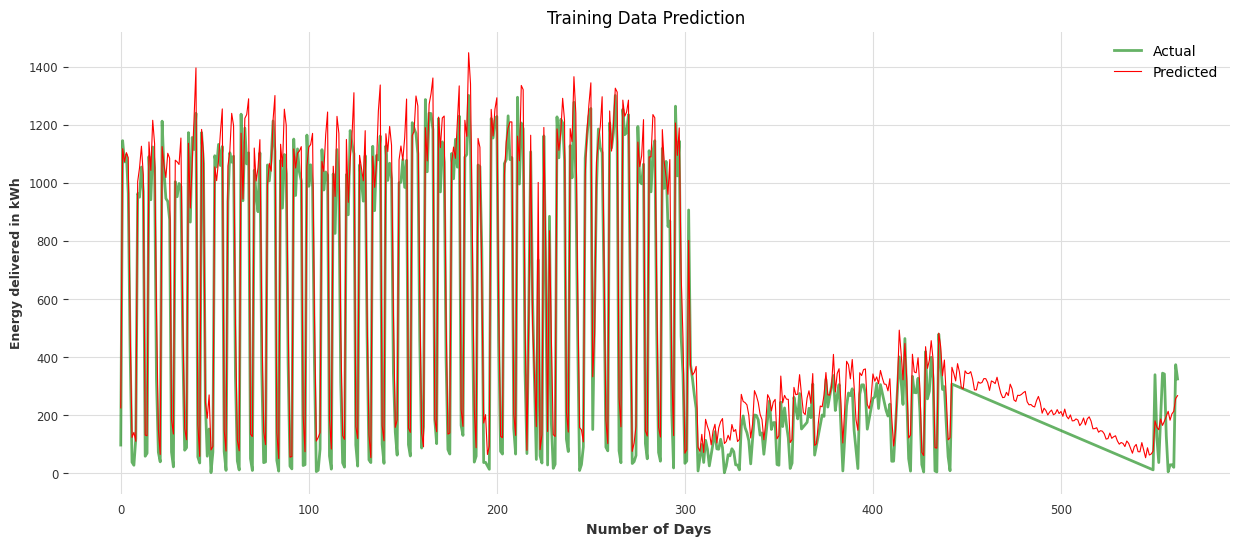

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(actual, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(predicted+50, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.title("Training Data Prediction ")
plt.ylabel('Energy delivered in kWh', fontsize=9)
plt.show()

30 days Prediction

In [ ]:
scaled_pred_nbeats = nbeats.predict(n=30)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
scaled_pred_nbeats=scaler.inverse_transform(scaled_pred_nbeats)

In [ ]:
scaled_pred_nbeats=concatenate(scaled_pred_nbeats)

In [ ]:
predicted=scaled_pred_nbeats.all_values()[:,0]

In [ ]:
predicted=predicted[:,0]
predicted=abs(predicted)

In [ ]:
actual=test.all_values()[:,0]
actual=actual[:,0]
actual=actual[:30]

In [ ]:
len(actual),len(predicted)

(30, 30)

In [ ]:
create_dataset(actual,predicted,"jpl_30days.csv")

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predicted,actual)

125.72125944161722

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predicted,actual,squared=False)

146.21507083237657

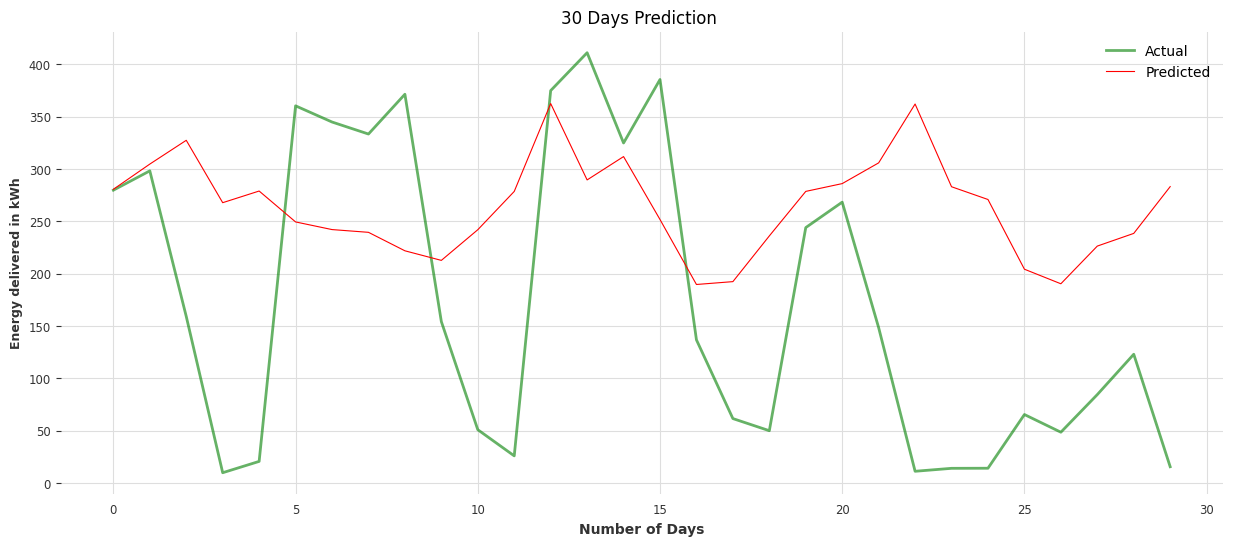

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(actual, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(predicted+50, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.title("30 Days Prediction ")
plt.ylabel('Energy delivered in kWh', fontsize=9)
plt.show()

120 days Prediction

In [ ]:
scaled_pred_nbeats = nbeats.predict(n=120)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
scaled_pred_nbeats=scaler.inverse_transform(scaled_pred_nbeats)

In [ ]:
scaled_pred_nbeats=concatenate(scaled_pred_nbeats)

In [ ]:
predicted=scaled_pred_nbeats.all_values()[:,0]

In [ ]:
predicted=predicted[:,0]

In [ ]:
predicted=abs(predicted)

In [ ]:
actual=test.all_values()[:,0]
actual=actual[:,0]
actual=actual[:120]

In [ ]:
len(actual),len(predicted)

(120, 120)

In [ ]:
create_dataset(actual,predicted,"jpl_120days.csv")

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predicted,actual)

163.87008080295072

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predicted,actual,squared=False)

184.74634522671144

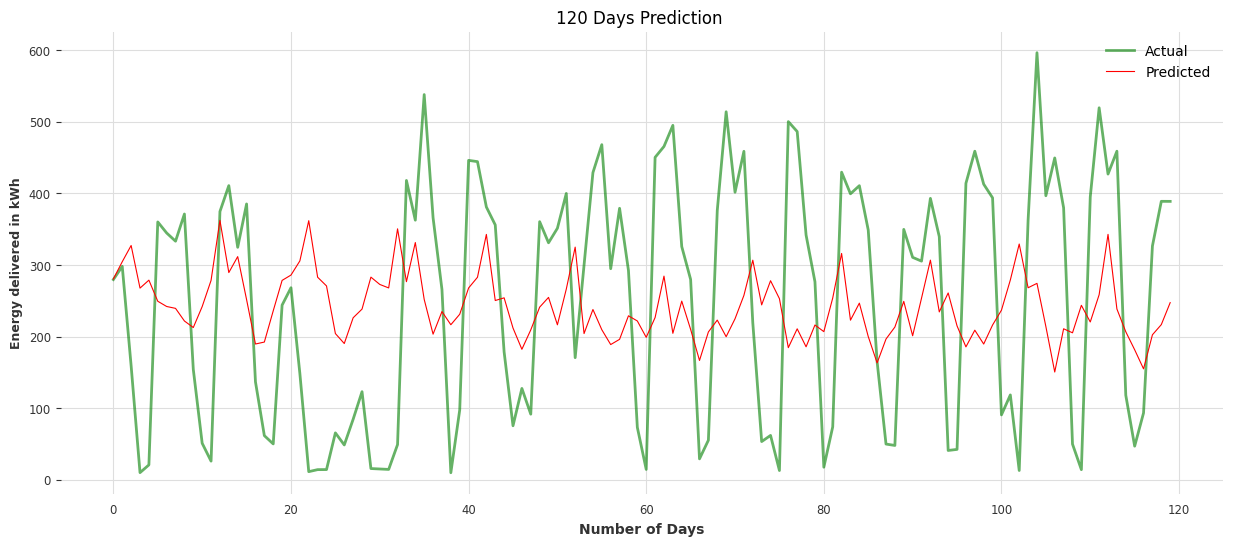

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(actual, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(predicted+50, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.title("120 Days Prediction ")
plt.ylabel('Energy delivered in kWh', fontsize=9)
plt.show()

200 days prediction

In [ ]:
scaled_pred_nbeats = nbeats.predict(n=287)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
scaled_pred_nbeats=scaler.inverse_transform(scaled_pred_nbeats)

In [ ]:
scaled_pred_nbeats=concatenate(scaled_pred_nbeats)

In [ ]:
predicted=scaled_pred_nbeats.all_values()[:,0]

In [ ]:
predicted=predicted[:,0]

In [ ]:
predicted=abs(predicted)

In [ ]:
actual=test.all_values()[:,0]
actual=actual[:,0]

In [ ]:
len(actual),len(predicted)

(287, 287)

In [ ]:
create_dataset(actual,predicted,"jpl_200days.csv")

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predicted,actual)

215.16076234277656

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(predicted,actual,squared=False)

257.0289110441504

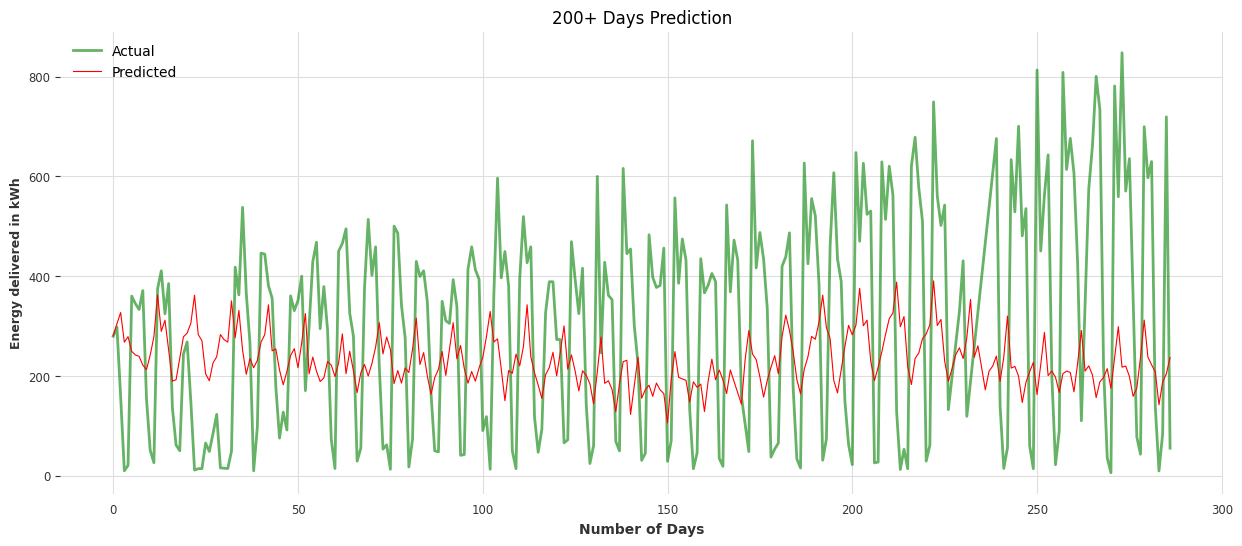

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(actual, color = 'green', linewidth=2.0, alpha = 0.6)
plt.plot(predicted+50, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.title("200+ Days Prediction")
plt.ylabel('Energy delivered in kWh', fontsize=9)
plt.show()

## XG Boost

In [ ]:
new_df.head()

Power    Duration
Date                           
2018-04-25  340.829  359.401667
2018-04-26  395.559  318.657500
2018-04-27  377.277  258.767500
2018-04-28  491.323  266.875833
2018-04-29  302.455  112.535556

In [ ]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from matplotlib import pyplot
from sklearn.impute import KNNImputer

Time Series Data Preparation

In [ ]:
imputer = KNNImputer(n_neighbors=10,metric='nan_euclidean')

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[0]
 df = DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
  cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
  cols.append(df.shift(-i))
 # put it all together
 agg = concat(cols, axis=1)
 # drop rows with NaN values
 agg = imputer.fit_transform(agg)
 return agg

In [ ]:
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

In [ ]:
def xgboost_forecast(train, testX, n_estimators):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict(asarray([testX]))
 return yhat[0]

In [ ]:
def walk_forward_validation(data, n_test, n_estimators):
 predictions = list()
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
 # split test row into input and output columns
  testX, testy = test[i, :-1], test[i, -1]
  # fit model on history and make a prediction
  yhat = xgboost_forecast(history, testX, n_estimators)
  # store forecast in list of predictions
  predictions.append(yhat)
  # add actual observation to history for the next loop
  history.append(test[i])
  # summarize progress
  print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 rmse=mean_squared_error(test[:, -1], predictions)
 return error,rmse, test[:, -1], predictions

In [ ]:
series = new_df
values = series.Power
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=20)
# evaluate
mae=10000
estimators=0
y=[]
yhat=[]
for i in range(1000,10000,1000):
  cols=list()
  cols=walk_forward_validation(data, 10, i)
  # mae, rmse,y, yhat = walk_forward_validation(data, 10,i)
  if mae>cols[0]:
    mae,rmse,y,yhat=cols
    estimators=i
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

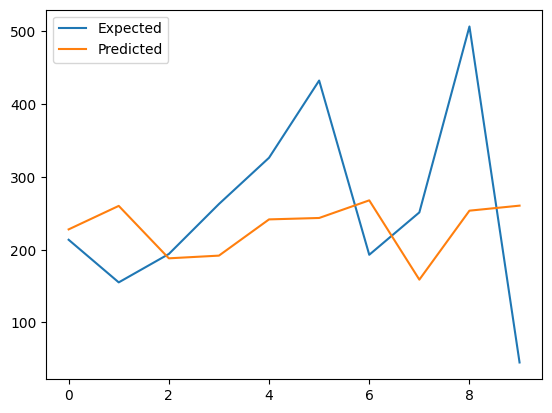

In [ ]:
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

## SVM for Caltech


In [ ]:
caltech.head()

Date    Power    Duration
0  2018-04-25  340.829  359.401667
1  2018-04-26  395.559  318.657500
2  2018-04-27  377.277  258.767500
3  2018-04-28  491.323  266.875833
4  2018-04-29  302.455  112.535556

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler


In [ ]:
energy=caltech

In [ ]:
energy.tail()

Date    Power    Duration
1080  2021-09-10  432.430  134.493611
1081  2021-09-11  193.040   33.257500
1082  2021-09-12  251.265   17.702778
1083  2021-09-13  506.718  129.661389
1084  2021-09-14   45.064    1.209167

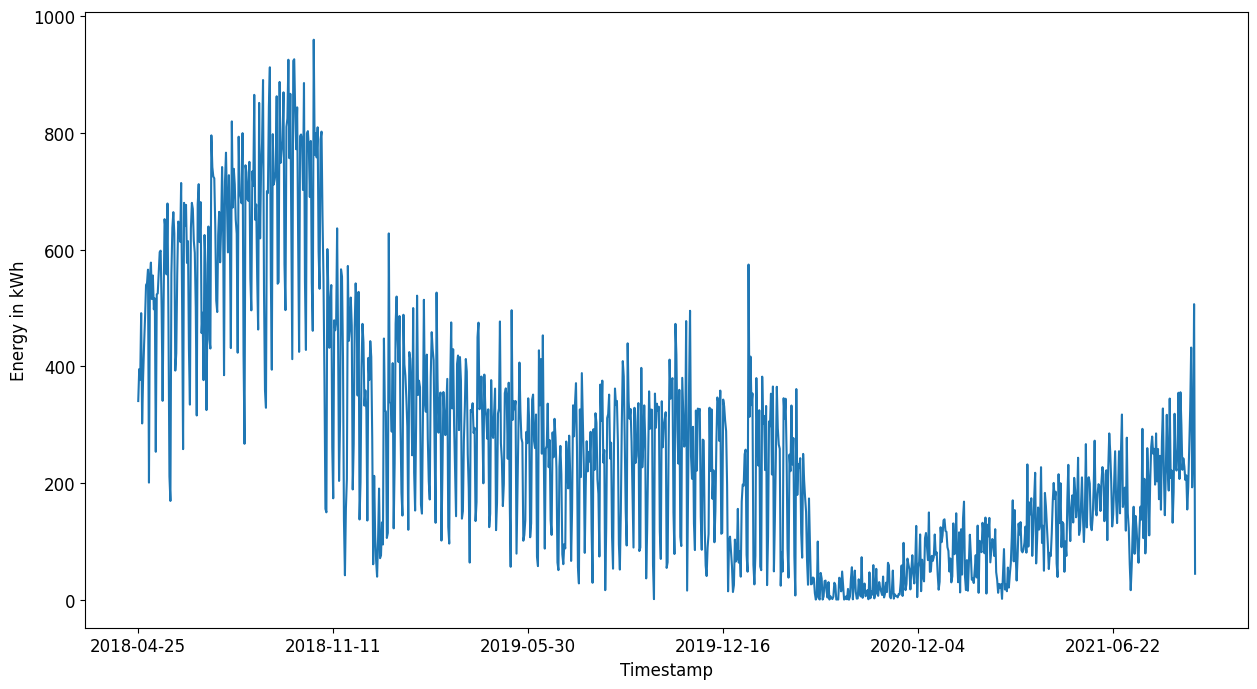

In [ ]:
energy.plot(y='Power',x='Date', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Energy in kWh', fontsize=12)
# plt.title("Caltech Dataset")
plt.legend().set_visible(False)
plt.show()

In [ ]:
energy.index=energy['Date']

In [ ]:
train_start_dt = '2018-04-25'
test_start_dt = '2021-01-01'

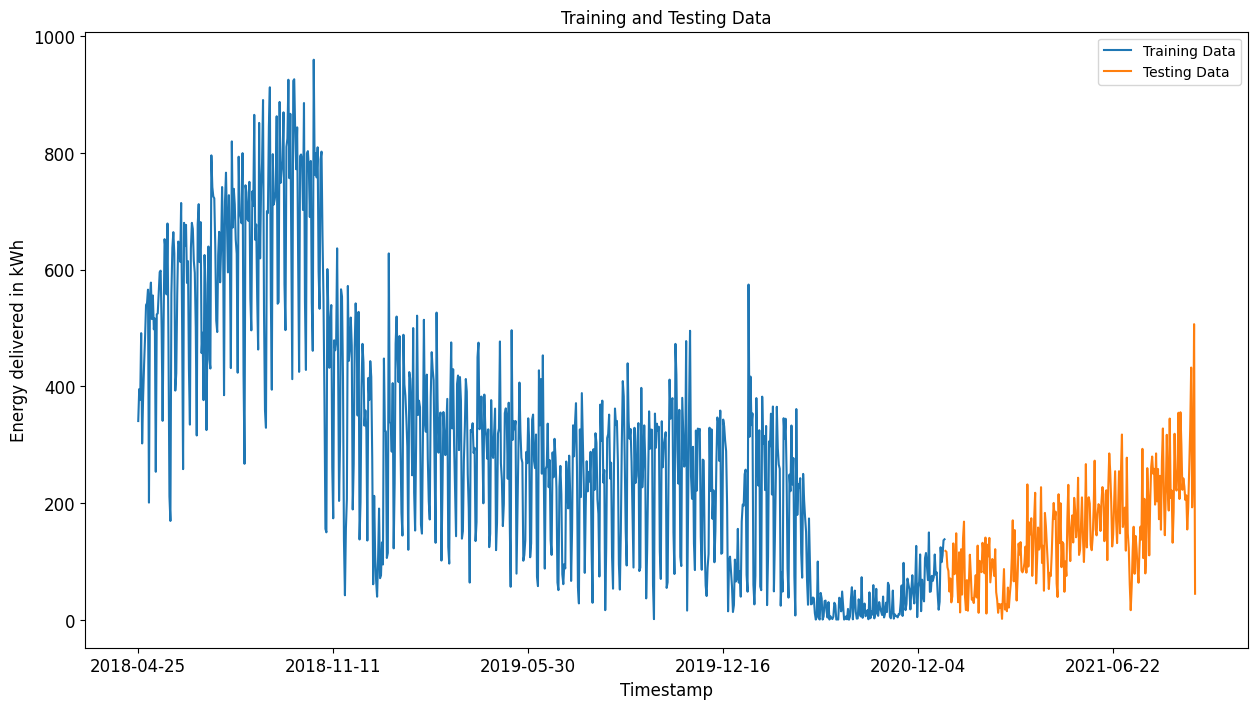

In [ ]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['Power']].rename(columns={'Power':'Training Data'}) \
    .join(energy[test_start_dt:][['Power']].rename(columns={'Power':'Testing Data'}), how='outer') \
    .plot(y=['Training Data', 'Testing Data'], figsize=(15, 8), fontsize=12)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Energy delivered in kWh', fontsize=12)
plt.title("Training and Testing Data")
plt.show()

In [ ]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['Power']]
test = energy.copy()[energy.index >= test_start_dt][['Power']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (828, 1)
Test data shape:  (257, 1)


In [ ]:
scaler = MinMaxScaler()
train['Power'] = scaler.fit_transform(train)
train.head(5)

Power
Date                
2018-04-25  0.354790
2018-04-26  0.411861
2018-04-27  0.392797
2018-04-28  0.511721
2018-04-29  0.314775

In [ ]:
test['Power'] = scaler.transform(test)
test.head(5)

Power
Date                
2021-01-01  0.122854
2021-01-02  0.121252
2021-01-03  0.093897
2021-01-04  0.087157
2021-01-05  0.050367

In [ ]:
train_data = train.values
test_data = test.values
timesteps=5

In [ ]:
#Converting test data to 2D tensor
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(824, 5)

In [ ]:
# Converting test data to 2D tensor

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(253, 5)

In [ ]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(824, 4) (824, 1)
(253, 4) (253, 1)


Model Creation and Evalutaion

In [ ]:
model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

In [ ]:
model.fit(x_train, y_train[:,0])

SVR(C=10, epsilon=0.05, gamma=0.5)

In [ ]:
y_train_pred = model.predict(x_train).reshape(-1,1)

In [ ]:
y_train_pred = scaler.inverse_transform(y_train_pred)

In [ ]:
train_timestamps = energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = energy[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

824 253


In [ ]:
temp=[]
for i in range(0,824):
  temp.append(i)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(scaler.inverse_transform(y_train),y_train_pred )

82.16026600841562

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(scaler.inverse_transform(y_train),y_train_pred,squared=False)

110.03387158995366

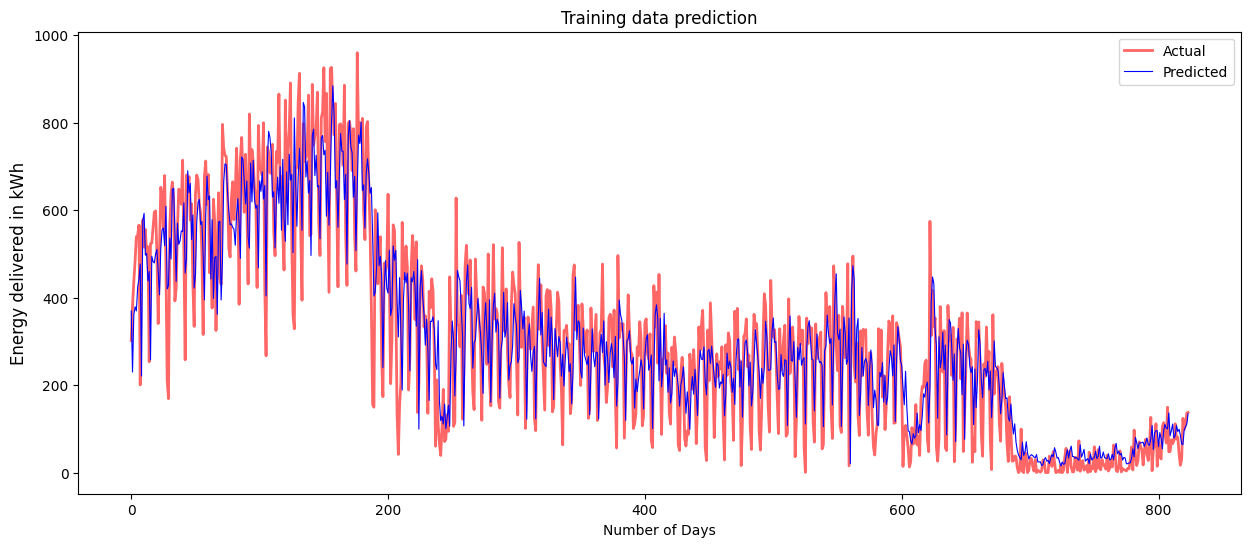

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(temp, scaler.inverse_transform(y_train), color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(temp, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh', fontsize=12)
plt.title("Training data prediction")
plt.show()

Predicting for 30 days

In [ ]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(824, 1) (253, 1)


In [ ]:
x_30=x_test[:30]
y_30=y_test[:30]

In [ ]:
x_30_predict=model.predict(x_30).reshape(-1,1)

In [ ]:
temp=[]
for i in range(0,30):
  temp.append(i)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(scaler.inverse_transform(y_30),scaler.inverse_transform(x_30_predict) )

51.76823080175796

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(scaler.inverse_transform(y_30),scaler.inverse_transform(x_30_predict),squared=False)

58.50687803188793

In [ ]:
x_30_predict

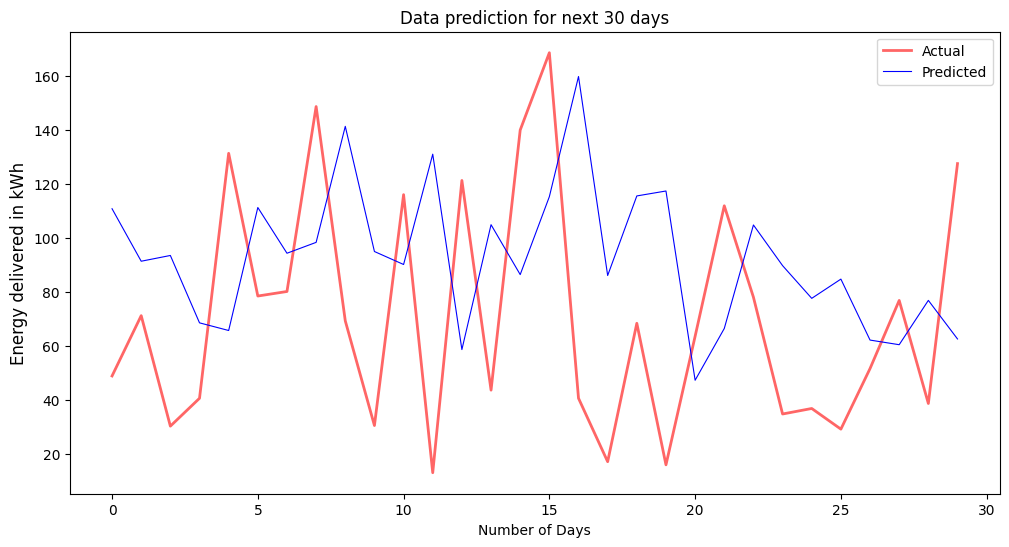

In [ ]:
plt.figure(figsize=(12,6))
plt.plot([i for i in range (0,30)], scaler.inverse_transform(y_30), color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot([i for i in range (0,30)], scaler.inverse_transform(x_30_predict), color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh', fontsize=12)
plt.title("Data prediction for next 30 days")
plt.show()

Prediction for 120 days

In [ ]:
x_120=x_test[:120]
y_120=y_test[:120]

In [ ]:
x_120_predict=model.predict(x_120).reshape(-1,1)

In [ ]:
temp=scaler.inverse_transform(x_120_predict)[:,0]
temp2=scaler.inverse_transform(y_120)[:,0]
create_dataset(temp2,temp,"caltech_120days.csv")

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(scaler.inverse_transform(y_120),scaler.inverse_transform(x_120_predict) )

45.129847135334515

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(scaler.inverse_transform(y_120),scaler.inverse_transform(x_120_predict),squared=False)

54.73190413380512

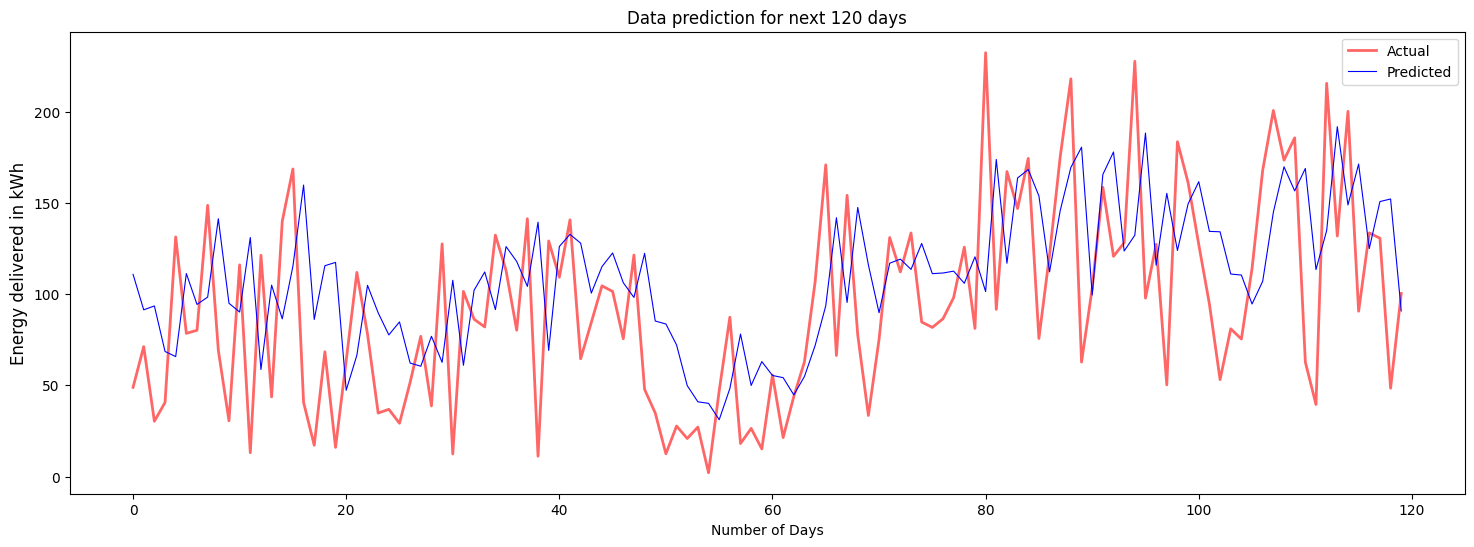

In [ ]:
plt.figure(figsize=(18,6))
plt.plot([i for i in range (0,120)], scaler.inverse_transform(y_120), color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot([i for i in range (0,120)], scaler.inverse_transform(x_120_predict), color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh', fontsize=12)
plt.title("Data prediction for next 120 days")
plt.show()

Prediction for 200 plus days

In [ ]:
y_predict=model.predict(x_test).reshape(-1,1)

In [ ]:
temp=scaler.inverse_transform(y_predict)[:,0]
temp2=scaler.inverse_transform(y_test)[:,0]
create_dataset(temp2,temp,"caltech_240days.csv")

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(scaler.inverse_transform(y_test),scaler.inverse_transform(y_predict) )

52.248351794344785

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(scaler.inverse_transform(y_predict),scaler.inverse_transform(y_test),squared=False)

68.14823341680902

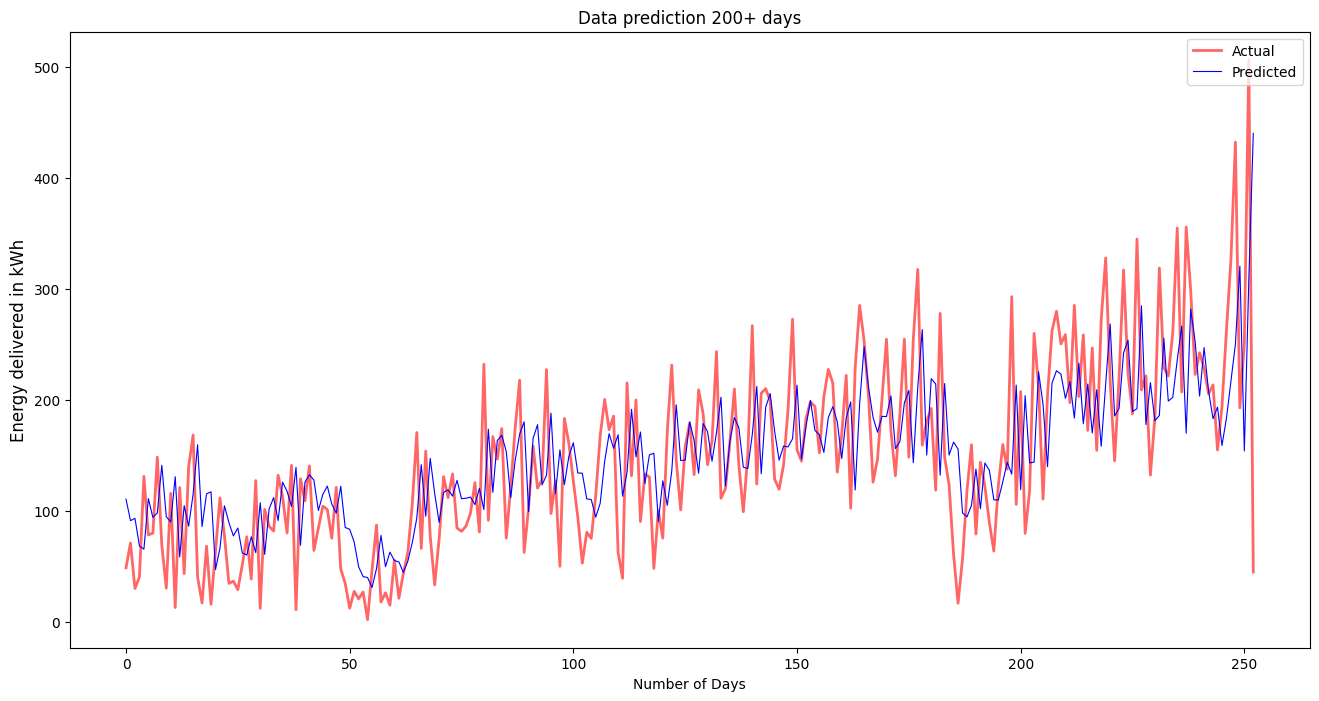

In [ ]:
plt.figure(figsize=(16,8))
plt.plot([i for i in range (0,len(y_predict))], scaler.inverse_transform(y_test), color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot([i for i in range (0,len(y_predict))], scaler.inverse_transform(y_predict), color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'],loc='upper right')
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh', fontsize=12)
plt.title("Data prediction 200+ days")
plt.show()

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(scaler.inverse_transform(y_train), y_train_pred)

0.7721546918860601

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(scaler.inverse_transform(y_train), y_train_pred)

82.18653150559226

In [ ]:
from numpy import sqrt
sqrt(mean_absolute_error(scaler.inverse_transform(y_train), y_train_pred))

9.06567876695354

## SVM for JPL

In [ ]:
jpl.head()

Date    Power
0  2018-09-05  245.799
1  2018-09-06  441.490
2  2018-09-07  462.517
3  2018-09-08   49.125
4  2018-09-09   22.435

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler


In [ ]:
energy=jpl

In [ ]:
energy.tail()

Date    Power
951  2021-09-10  138.765
952  2021-09-11    9.554
953  2021-09-12   84.675
954  2021-09-13  719.547
955  2021-09-14   55.190

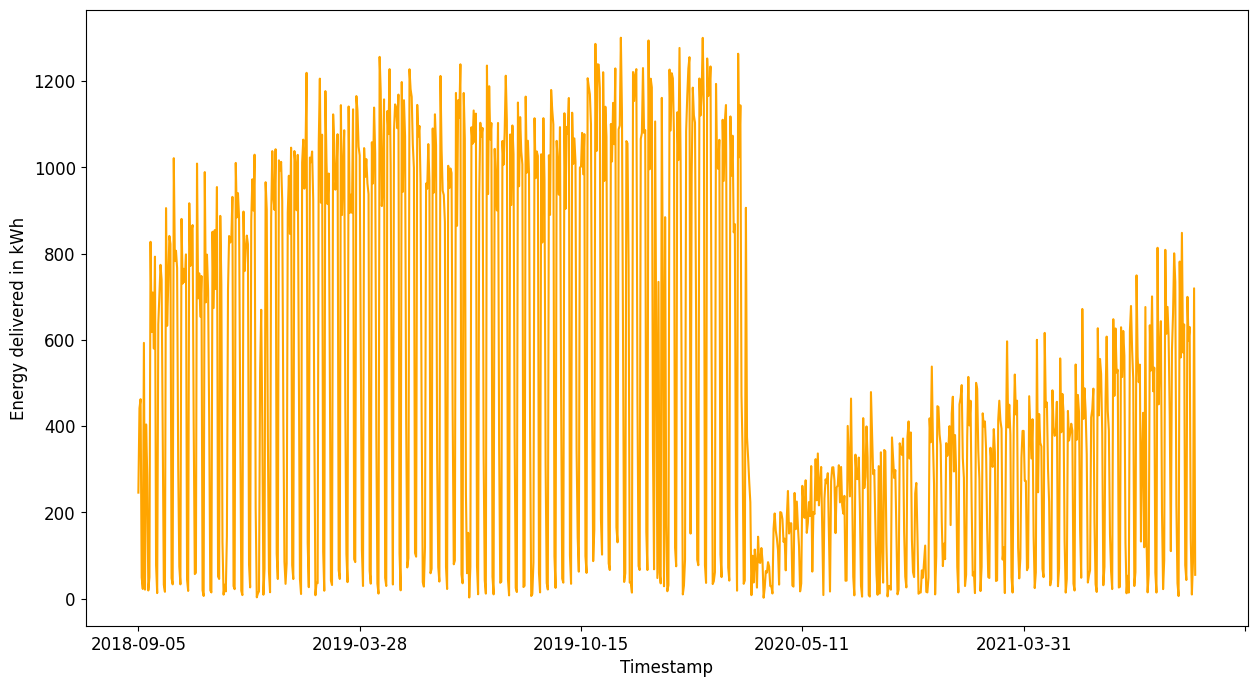

In [ ]:
energy.plot(y='Power',x='Date', subplots=True, figsize=(15, 8), fontsize=12,color="orange")
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Energy delivered in kWh', fontsize=12)
# plt.title("JPL Data")
plt.legend().set_visible(False)
plt.show()

In [ ]:
energy.index=energy['Date']

In [ ]:
train_start_dt = '2018-04-25'
test_start_dt = '2021-02-01'

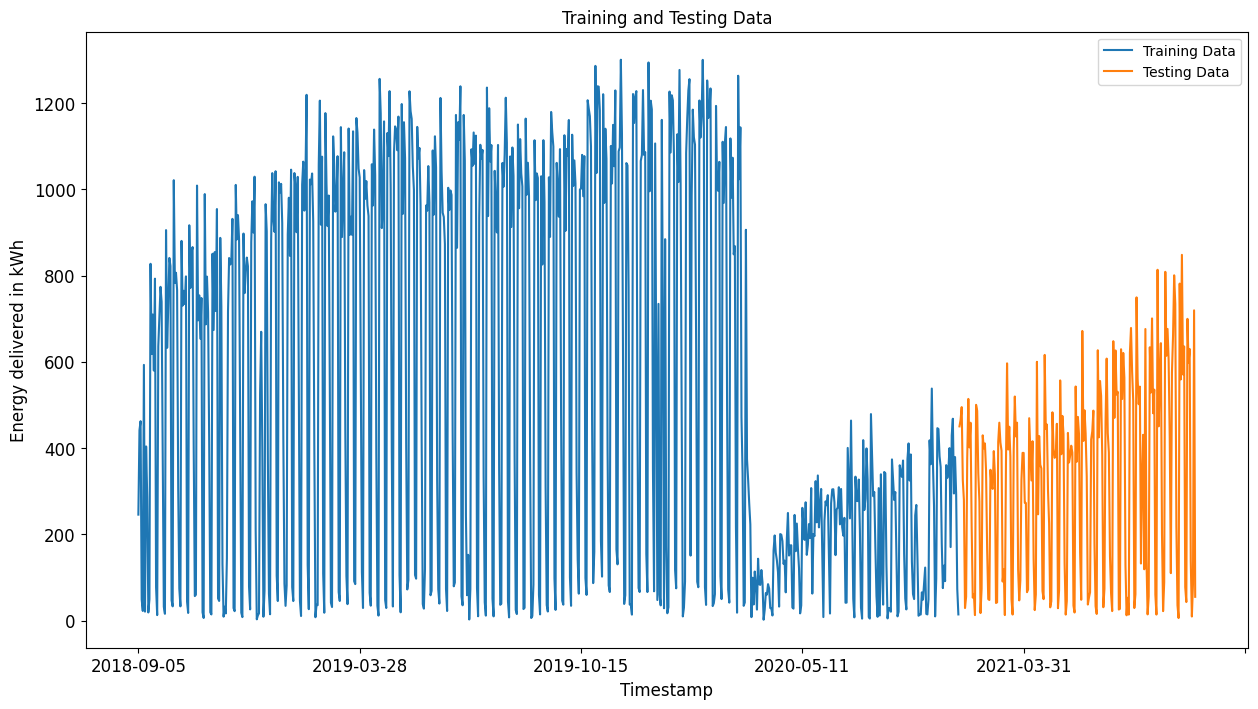

In [ ]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['Power']].rename(columns={'Power':'Training Data'}) \
    .join(energy[test_start_dt:][['Power']].rename(columns={'Power':'Testing Data'}), how='outer') \
    .plot(y=['Training Data', 'Testing Data'], figsize=(15, 8), fontsize=12)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Energy delivered in kWh', fontsize=12)
plt.title("Training and Testing Data")
plt.show()

In [ ]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['Power']]
test = energy.copy()[energy.index >= test_start_dt][['Power']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (742, 1)
Test data shape:  (214, 1)


In [ ]:
scaler = MinMaxScaler()
train['Power'] = scaler.fit_transform(train)
train.head(5)

Power
Date                
2018-09-05  0.187670
2018-09-06  0.338368
2018-09-07  0.354560
2018-09-08  0.036215
2018-09-09  0.015661

In [ ]:
test['Power'] = scaler.transform(test)
test.head(5)

Power
Date                
2021-02-01  0.345259
2021-02-02  0.356974
2021-02-03  0.379675
2021-02-04  0.249280
2021-02-05  0.213892

In [ ]:
train_data = train.values
test_data = test.values
timesteps=5

In [ ]:
#Converting test data to 2D tensor
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(738, 5)

In [ ]:
# Converting test data to 2D tensor

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(210, 5)

In [ ]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(738, 4) (738, 1)
(210, 4) (210, 1)


Model Creation and Evalutaion

In [ ]:
model = SVR(kernel='rbf',gamma=0.6, C=20, epsilon = 0.03)

In [ ]:
model.fit(x_train, y_train[:,0])

SVR(C=20, epsilon=0.03, gamma=0.6)

In [ ]:
y_train_pred = model.predict(x_train).reshape(-1,1)

In [ ]:
temp=scaler.inverse_transform(y_train_pred)[:,0]
temp2=scaler.inverse_transform(y_train)[:,0]
create_dataset(temp2,temp,"jpl_train.csv")

In [ ]:
y_train_pred = scaler.inverse_transform(y_train_pred)

In [ ]:
train_timestamps = energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = energy[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

738 210


In [ ]:
temp=[]
for i in range(0,738):
  temp.append(i)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(scaler.inverse_transform(y_train),y_train_pred )

154.20792255164469

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(scaler.inverse_transform(y_train),y_train_pred,squared=False)

255.61058381980573

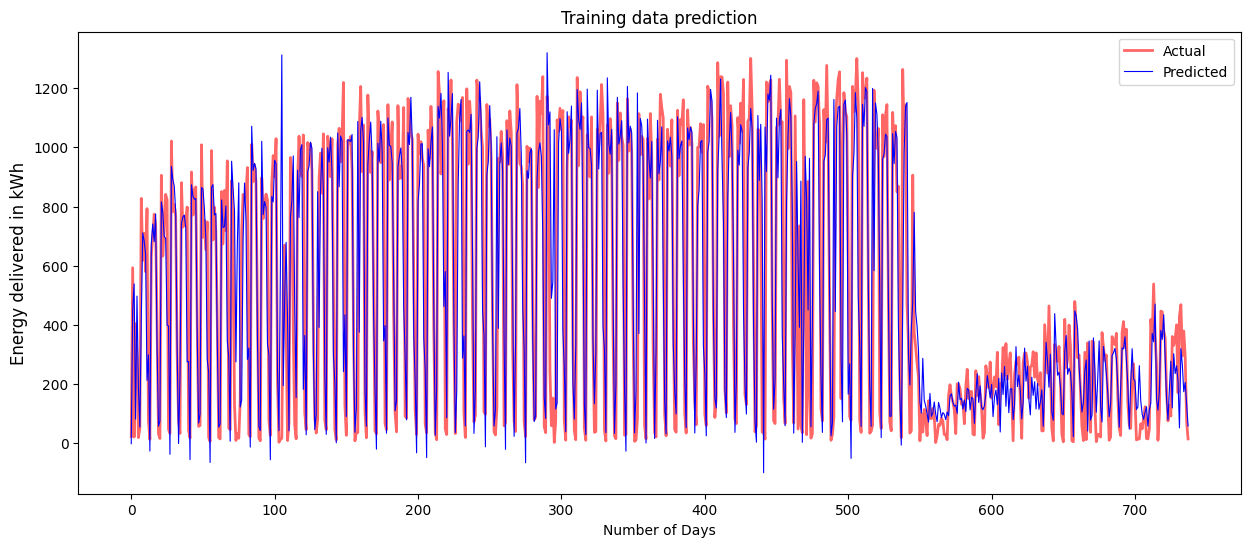

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(temp, scaler.inverse_transform(y_train), color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(temp, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh', fontsize=12)
plt.title("Training data prediction")
plt.show()

Predicting for 30 days

In [ ]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(738, 1) (210, 1)


In [ ]:
x_30=x_test[:30]
y_30=y_test[:30]

In [ ]:
x_30_predict=model.predict(x_30).reshape(-1,1)

In [ ]:
temp=scaler.inverse_transform(x_30_predict)[:,0]
temp2=scaler.inverse_transform(y_30)[:,0]
create_dataset(temp2,temp,"jpl_30days.csv")

In [ ]:
temp=[]
for i in range(0,30):
  temp.append(i)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(scaler.inverse_transform(y_30),scaler.inverse_transform(x_30_predict) )

96.33005671074024

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(scaler.inverse_transform(y_30),scaler.inverse_transform(x_30_predict),squared=False)

131.00057320071681

In [ ]:
x_30_predict

array([[0.07508972],
       [0.10331466],
       [0.10409806],
       [0.24415769],
       [0.25042528],
       [0.37056188],
       [0.27048565],
       [0.16755126],
       [0.0387245 ],
       [0.12158357],
       [0.31538901],
       [0.12539694],
       [0.34398813],
       [0.34249455],
       [0.24026851],
       [0.09592003],
       [0.10207844],
       [0.26766456],
       [0.26845377],
       [0.29034962],
       [0.25060074],
       [0.10679403],
       [0.05271607],
       [0.16657674],
       [0.22817119],
       [0.22398878],
       [0.19793933],
       [0.18558557],
       [0.16918037],
       [0.12655594]])

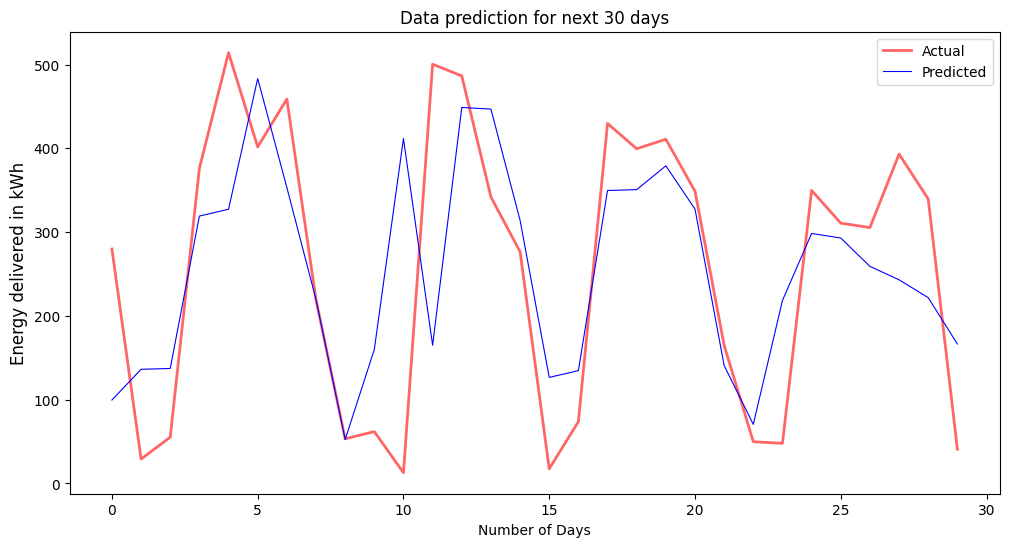

In [ ]:
plt.figure(figsize=(12,6))
plt.plot([i for i in range (0,30)], scaler.inverse_transform(y_30), color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot([i for i in range (0,30)], scaler.inverse_transform(x_30_predict), color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh', fontsize=12)
plt.title("Data prediction for next 30 days")
plt.show()

Prediction for 120 days

In [ ]:
x_120=x_test[:120]
y_120=y_test[:120]

In [ ]:
x_120_predict=model.predict(x_120).reshape(-1,1)

In [ ]:
temp=scaler.inverse_transform(x_120_predict)[:,0]
temp2=scaler.inverse_transform(y_120)[:,0]
create_dataset(temp2,temp,"jpl_120days.csv")

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(scaler.inverse_transform(y_120),scaler.inverse_transform(x_120_predict) )

102.52801238281712

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(scaler.inverse_transform(y_120),scaler.inverse_transform(x_120_predict),squared=False)

136.0776816123859

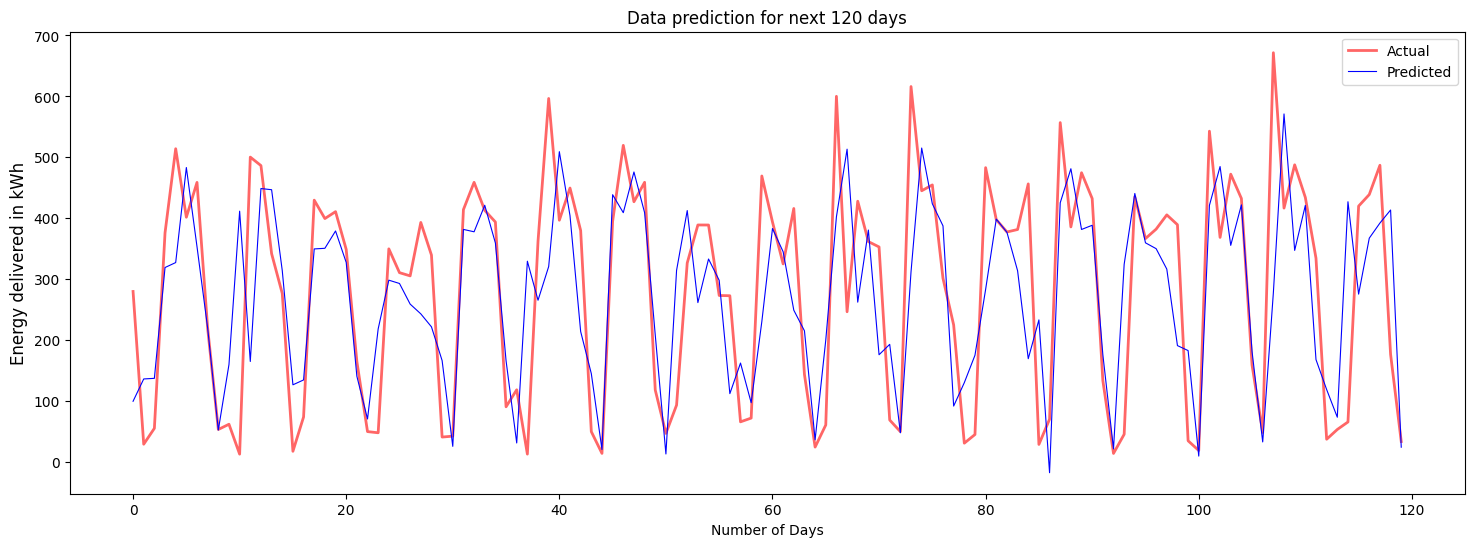

In [ ]:
plt.figure(figsize=(18,6))
plt.plot([i for i in range (0,120)], scaler.inverse_transform(y_120), color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot([i for i in range (0,120)], scaler.inverse_transform(x_120_predict), color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh', fontsize=12)
plt.title("Data prediction for next 120 days")
plt.show()

Prediction for 200 plus days

In [ ]:
y_predict=model.predict(x_test).reshape(-1,1)

In [ ]:
temp=scaler.inverse_transform(y_predict)[:,0]
temp2=scaler.inverse_transform(y_test)[:,0]
create_dataset(temp2,temp,"jpl_240days.csv")

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(scaler.inverse_transform(y_test),scaler.inverse_transform(y_predict) )

127.05626174944486

In [ ]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(scaler.inverse_transform(y_predict),scaler.inverse_transform(y_test),squared=False)

175.4827599381593

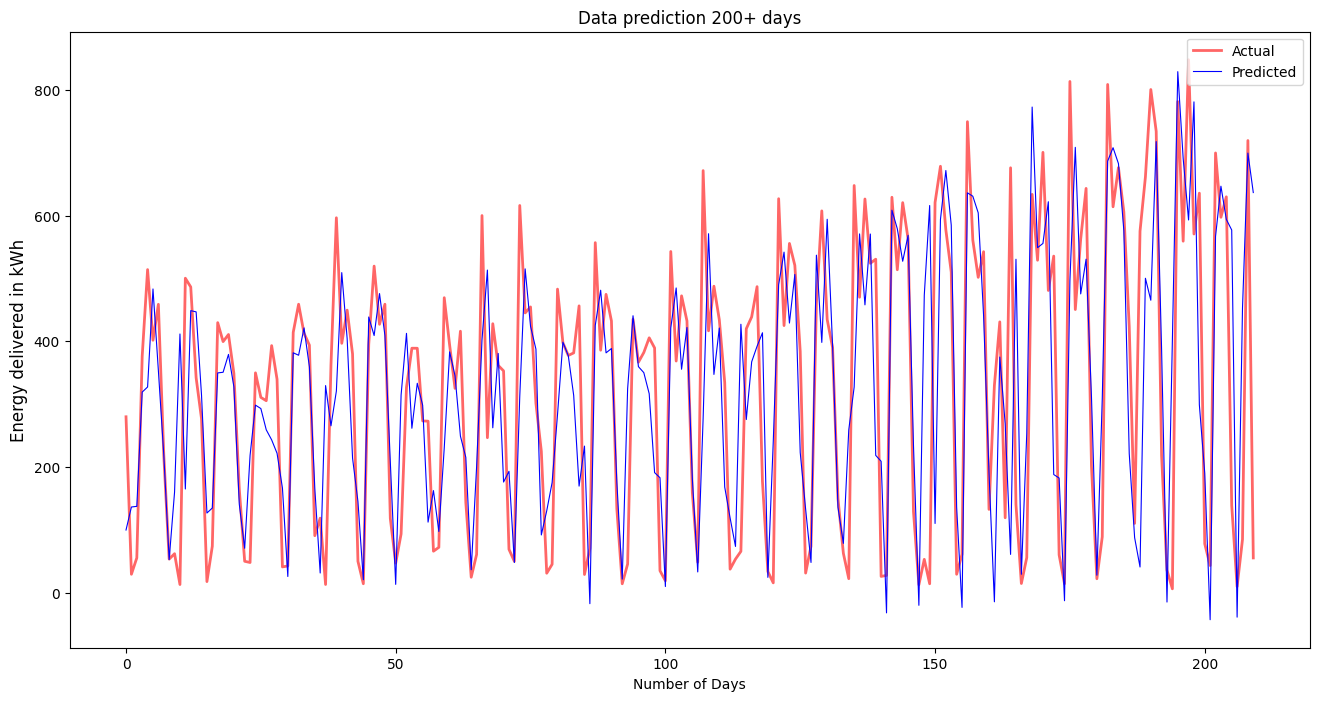

In [ ]:
plt.figure(figsize=(16,8))
plt.plot([i for i in range (0,len(y_predict))], scaler.inverse_transform(y_test), color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot([i for i in range (0,len(y_predict))], scaler.inverse_transform(y_predict), color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'],loc='upper right')
plt.xlabel('Number of Days')
plt.ylabel('Energy delivered in kWh', fontsize=12)
plt.title("Data prediction 200+ days")
plt.show()

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(scaler.inverse_transform(y_train), y_train_pred)

0.7721546918860601

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(scaler.inverse_transform(y_train), y_train_pred)

82.18653150559226

In [ ]:
from numpy import sqrt
sqrt(mean_absolute_error(scaler.inverse_transform(y_train), y_train_pred))

9.06567876695354

## Comparison of Models


## Short Term (30 days)

In [ ]:
def normalize_by_max(array):
  max_value = np.max(array)
  normalized_array = array / max_value
  return normalized_array

In [ ]:
mae = [10,20,20,40]

In [ ]:
print(normalize_by_max(mae))

[0.25 0.5  0.5  1.  ]


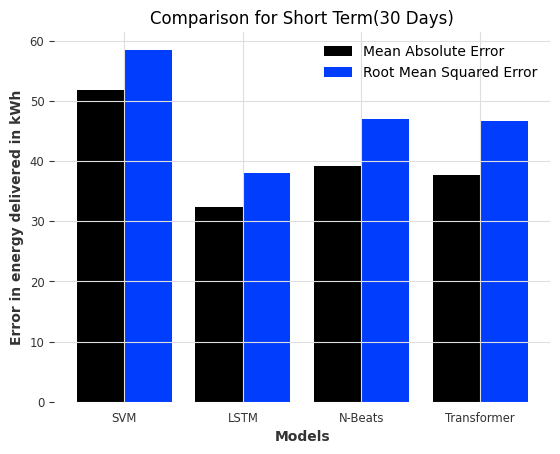

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

X = ['SVM','LSTM','N-Beats','Transformer']
rmse = [58.506,38.0221,47.0507,46.6468]
mae = [51.768,32.3416,39.1083,37.6183]

X_axis = np.arange(len(X))

plt.bar(X_axis -0.2 , mae,0.4, label = 'Mean Absolute Error')
plt.bar(X_axis +0.2, rmse, 0.4,label = 'Root Mean Squared Error')

plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.ylabel("Error in energy delivered in kWh")
plt.title("Comparison for Short Term(30 Days)")
plt.legend()
plt.show()


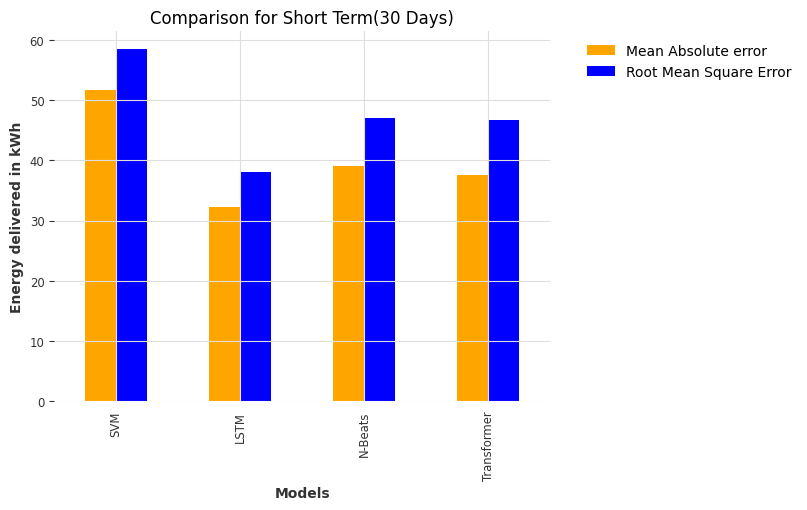

In [ ]:

import matplotlib.pyplot as plot
import pandas as pd

# Make a data definition
_data = {'Root Mean Square Error' : [58.506,38.0221,47.0507,46.6468],
        'Mean Absolute error': [51.768,32.3416,39.1083,37.6183]}
_df = pd.DataFrame(_data,columns=['Mean Absolute error','Root Mean Square Error'], index = ['SVM','LSTM','N-Beats','Transformer'])

# Multiple bar chart
_df.plot.bar(color=["orange","blue"])
plot.xlabel("Models")
plot.ylabel("Energy delivered in kWh")
plot.title("Comparison for Short Term(30 Days)")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# Display the plot
plot.show()


In [ ]:
51.768,32.3416,39.1083,37.6183

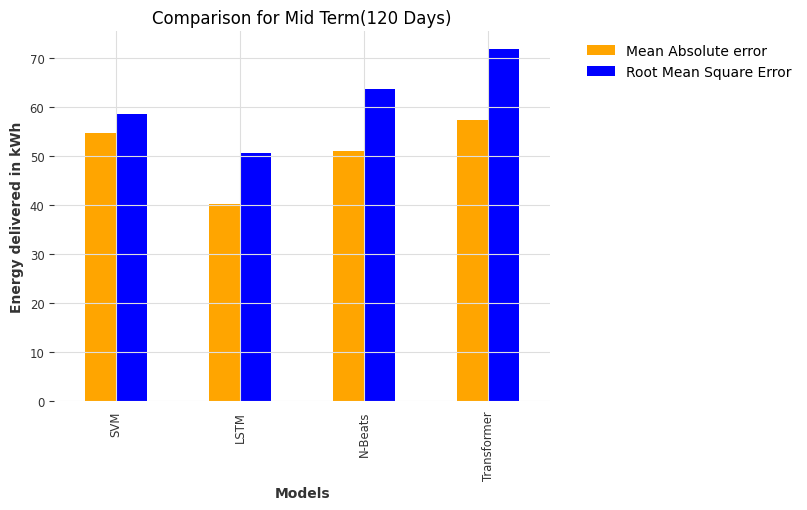

In [ ]:
import matplotlib.pyplot as plot
import pandas as pd

# Make a data definition
_data = {'Root Mean Square Error' : [58.5068,50.7040,63.7439,71.8325],
        'Mean Absolute error': [54.7319,40.2456,50.9405,57.4163]}
_df = pd.DataFrame(_data,columns=['Mean Absolute error','Root Mean Square Error'], index = ['SVM','LSTM','N-Beats','Transformer'])

# Multiple bar chart
_df.plot.bar(color=["orange","blue"])
plot.xlabel("Models")
plot.ylabel("Energy delivered in kWh")
plot.title("Comparison for Mid Term(120 Days)")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# Display the plot
plot.show()

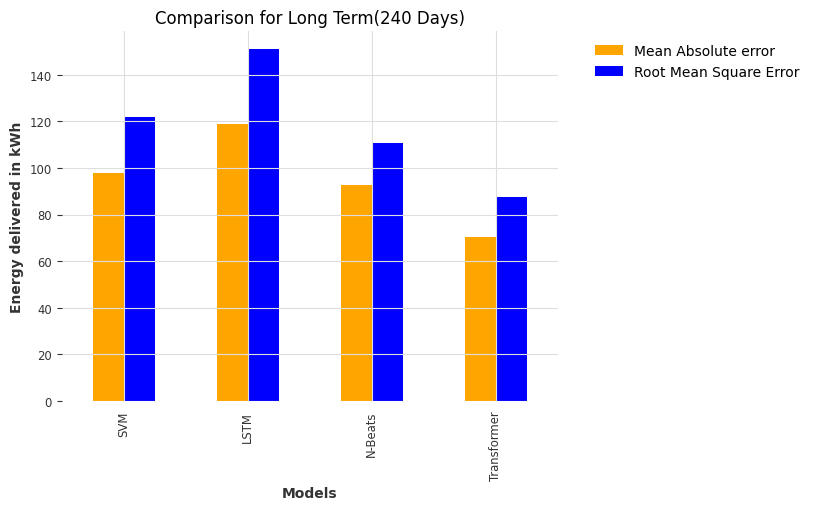

In [ ]:
import matplotlib.pyplot as plot
import pandas as pd

# Make a data definition
_data = {'Root Mean Square Error' : [121.8956,151.0258,110.7754,87.4525],
        'Mean Absolute error': [97.6583,118.9311,92.5697,70.4163]}
_df = pd.DataFrame(_data,columns=['Mean Absolute error','Root Mean Square Error'], index = ['SVM','LSTM','N-Beats','Transformer'])

# Multiple bar chart
_df.plot.bar(color=["orange","blue"])
plot.xlabel("Models")
plot.ylabel("Energy delivered in kWh")
plot.title("Comparison for Long Term(240 Days)")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# Display the plot
plot.show()

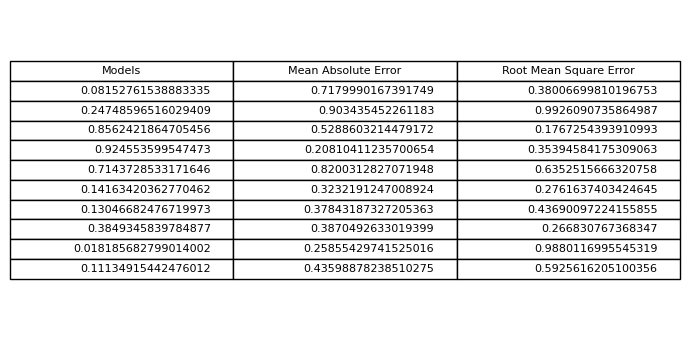

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
data = np.random.random((10, 3))
columns = ("Models", "Mean Absolute Error", "Root Mean Square Error")
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=data, colLabels=columns, loc='center')
plt.show()